# Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import PIL
import torch
import torchvision
import urllib
import cv2

In [ ]:
# !apt-get install imagemagick

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 1. Variants of Backprop for visualizing CNNs

In [ ]:
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "classes.txt")
with open("classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

In [ ]:
def prep_input(path):
  img = PIL.Image.open(path)

  preprocess_transform = torchvision.transforms.Compose([
                         torchvision.transforms.Resize(256),
                         torchvision.transforms.CenterCrop(224),
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                         ])

  img = preprocess_transform(img)
  img.unsqueeze_(0)

  return img

def prep_output(img_tensor):
  process_transform = torchvision.transforms.Compose([
                      torchvision.transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]),
                      torchvision.transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]),
                      ])
  out = process_transform(img_tensor)[0]
  out = out.detach().numpy().transpose(1, 2, 0)

  return out



def plot_results(img1, img2, vmin=0.3, vmax=0.7, mix_val=2):
  flattened_img1 = norm_flat_image(img1)
  flattened_img2 = norm_flat_image(img2)
  fig, axes = plt.subplots(1, 3)
  fig.set_figheight(20)
  fig.set_figwidth(45)
  axes[0].imshow(flattened_img1, vmin=vmin, vmax=vmax, cmap="gray")
  axes[0].axis('off')
  axes[0].set_title('Saliency map', fontsize=40)
  axes[1].imshow(flattened_img2, cmap="gray")
  axes[1].axis('off')
  axes[1].set_title('Input image', fontsize=40)
  axes[2].imshow((flattened_img1 * mix_val) + (flattened_img2/mix_val), cmap = "gray")
  axes[2].axis('off')
  axes[2].set_title('Overlay', fontsize=40)
  plt.show()

def norm_flat_image(img):
  grads_norm = prep_output(img)
  grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]
  grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
  return grads_norm

In [ ]:
paths = ["i1.jpg", "i2.jpg", "i3.jpg", "i4.jpg", "i5.jpg"]

In [ ]:
def vanilla_backprop(path):
  img = prep_input(path)
  img.requires_grad = True
  model = torchvision.models.resnet50(True)
  model.eval()
  output = model(img)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  top5_probabilities, top5_classes = torch.topk(probabilities, 5)
  for i in range(5):
    print(categories[top5_classes[i]], top5_probabilities[i].item())
    # print("Class {} has probability {}".format(categories[top5_probabilities[i]], top5_classes[i].item()))
  predicted_class = output.argmax()
  model.zero_grad()
  score = output[0, predicted_class]
  score.backward()
  grads = img.grad
  plot_results(grads, img)

In [ ]:
def relu_back_hook(module, incoming_gradient, outgoing_gradient):
  if isinstance(module, torch.nn.ReLU):
    return (torch.clamp(incoming_gradient[0], min=0.),)

def guided_backprop(path, info=True):
  img = prep_input(path)
  img.requires_grad = True
  model = torchvision.models.resnet50(True)
  model.eval()
  for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
      module.register_backward_hook(relu_back_hook)
  output = model(img)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  top5_probabilities, top5_classes = torch.topk(probabilities, 5)
  for i in range(5):
    if info:
      print(categories[top5_classes[i]], top5_probabilities[i].item())
    # print("Class {} has probability {}".format(categories[top5_probabilities[i]], top5_classes[i].item()))
  predicted_class = output.argmax()
  model.zero_grad()
  score = output[0, predicted_class]
  score.backward()
  grads = img.grad
  if info:
    plot_results(grads, img)
  return norm_flat_image(grads)

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def class_activation_map(path):
  img = prep_input(path)
  img.requires_grad = True
  model = torchvision.models.resnet50(True)
  model.eval()
  model.layer4[2].relu.register_forward_hook(get_activation('conv'))
  output = model(img)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  top5_probabilities, top5_classes = torch.topk(probabilities, 5)
  for i in range(5):
    print(categories[top5_classes[i]], top5_probabilities[i].item())
  predicted_class = output.argmax()
  features = activation['conv']
  fc_weights = model.fc.weight[predicted_class, :]
  cam = torch.sum(fc_weights.unsqueeze(-1).unsqueeze(-1) * features, dim=1)
  cam = torch.nn.functional.relu(cam)
  cam = (cam - torch.min(cam))/ (torch.max(cam) - torch.min(cam))

  resize = torchvision.transforms.Resize(224)
  cam = resize(cam)
  cam = cam[0]
  cmap = plt.colormaps.get_cmap('viridis')
  heatmap = cmap(cam.detach())[:, :, :3]
  img = prep_output(img)

  fig, axes = plt.subplots(1, 3)
  fig.set_figheight(20)
  fig.set_figwidth(45)
  axes[0].imshow(heatmap)
  axes[0].axis('off')
  axes[0].set_title('Heatmap', fontsize=40)
  axes[1].imshow(img)
  axes[1].axis('off')
  axes[1].set_title('Input image', fontsize=40)
  axes[2].imshow((heatmap * 0.6) + (img * 0.4))
  axes[2].axis('off')
  axes[2].set_title('Overlay', fontsize=40)
  plt.show()


1===========================================================
German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197


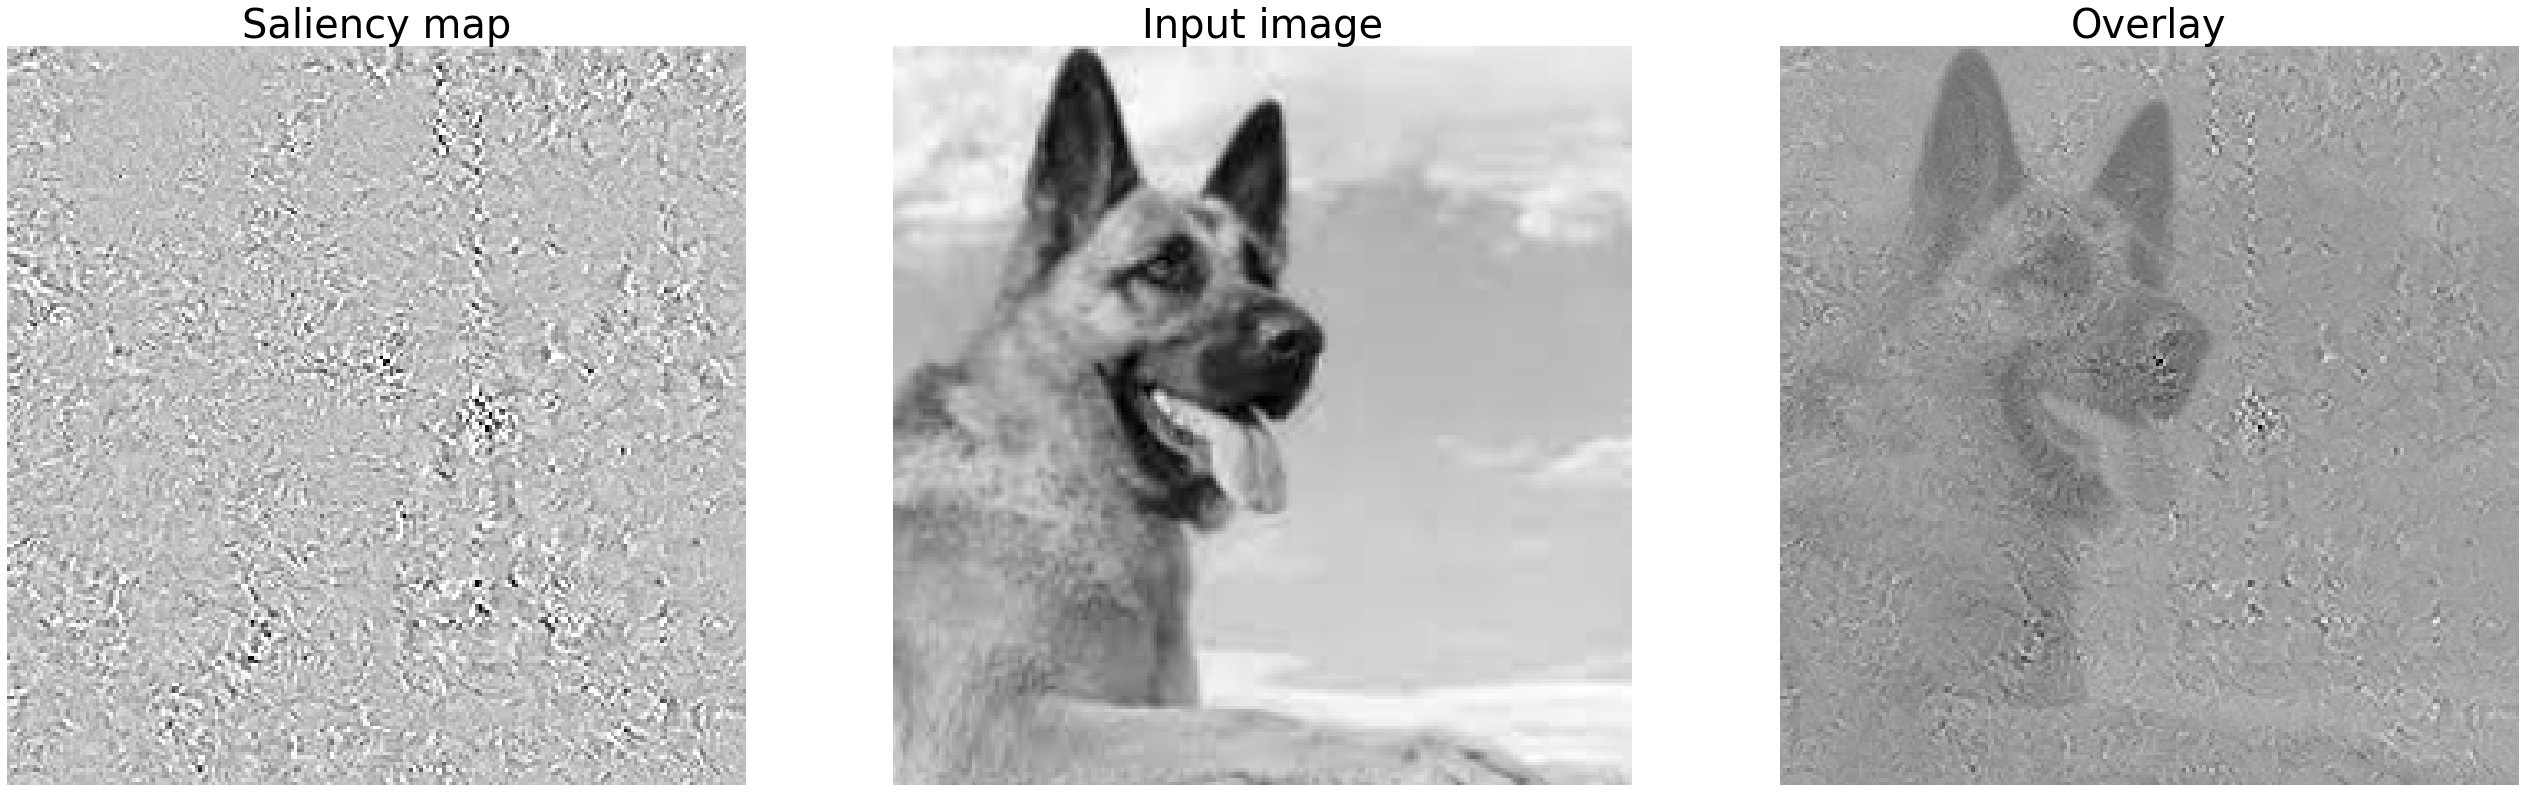


2===========================================================
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755


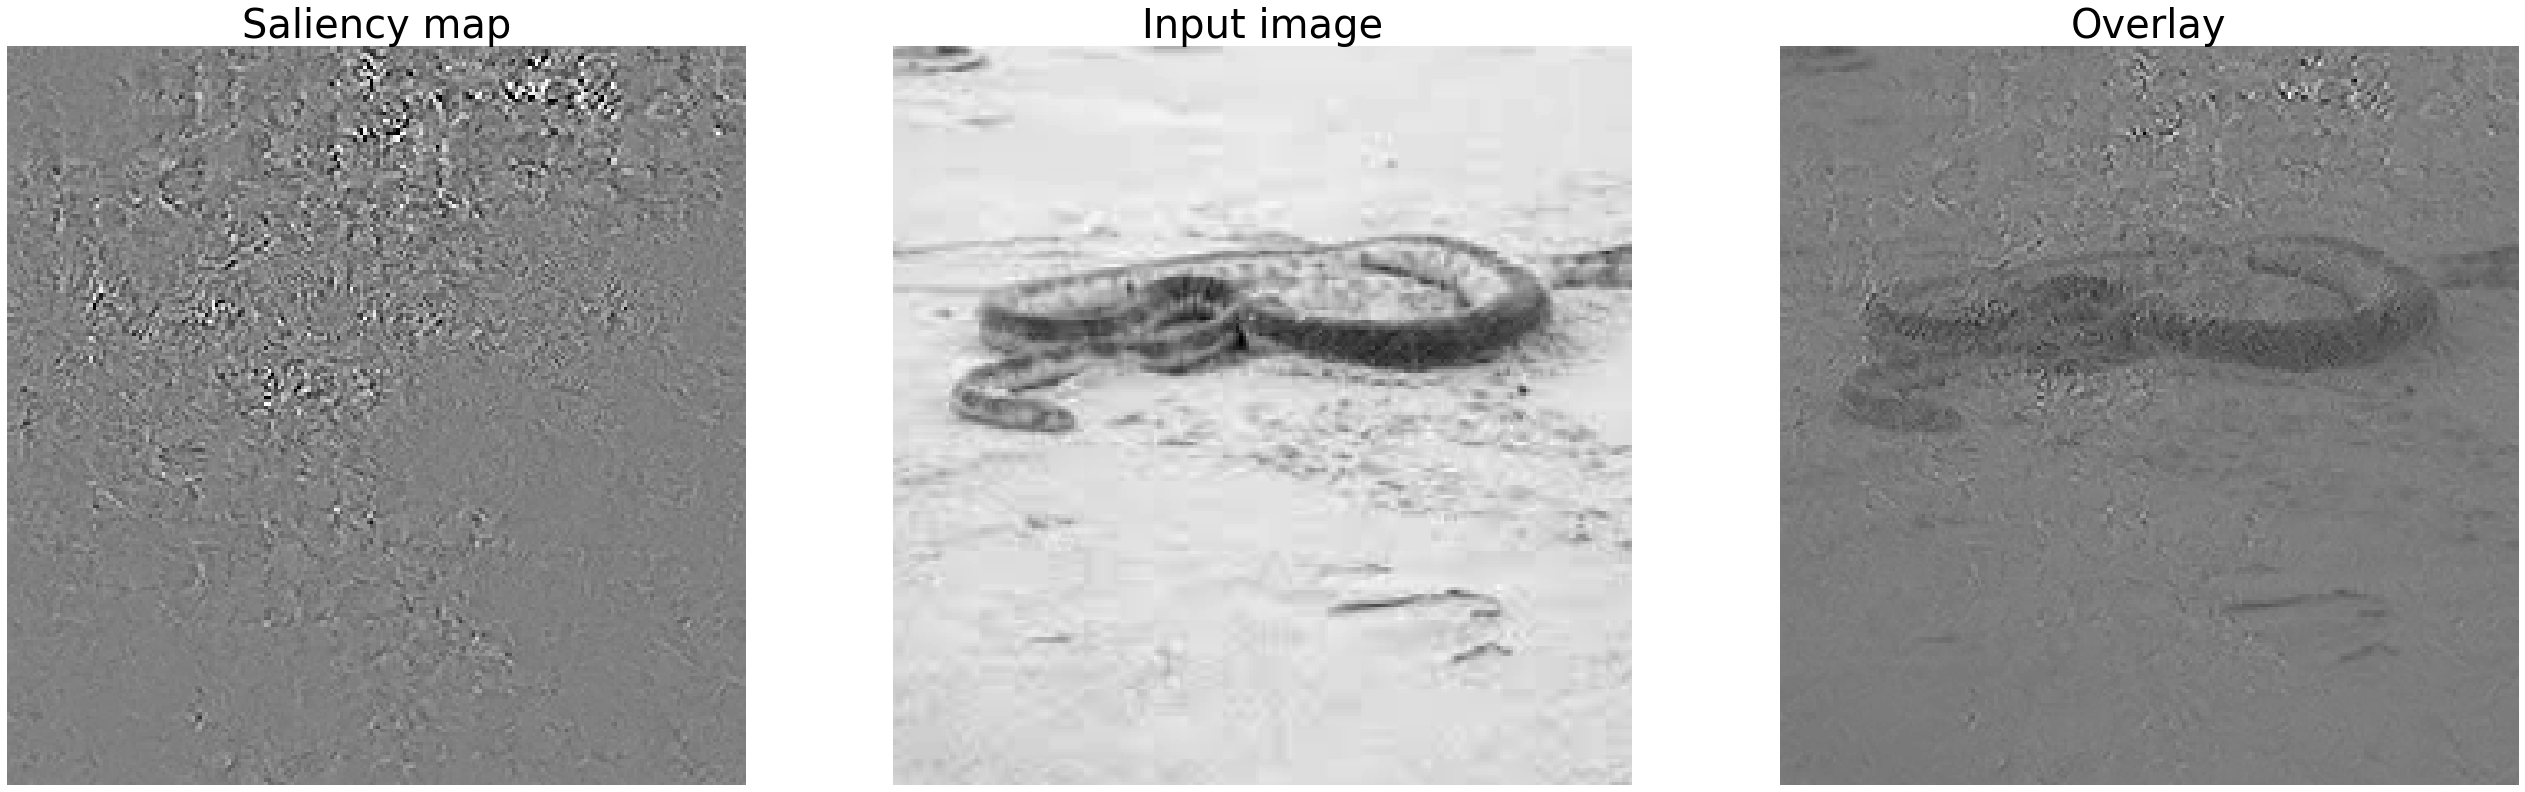


3===========================================================
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946


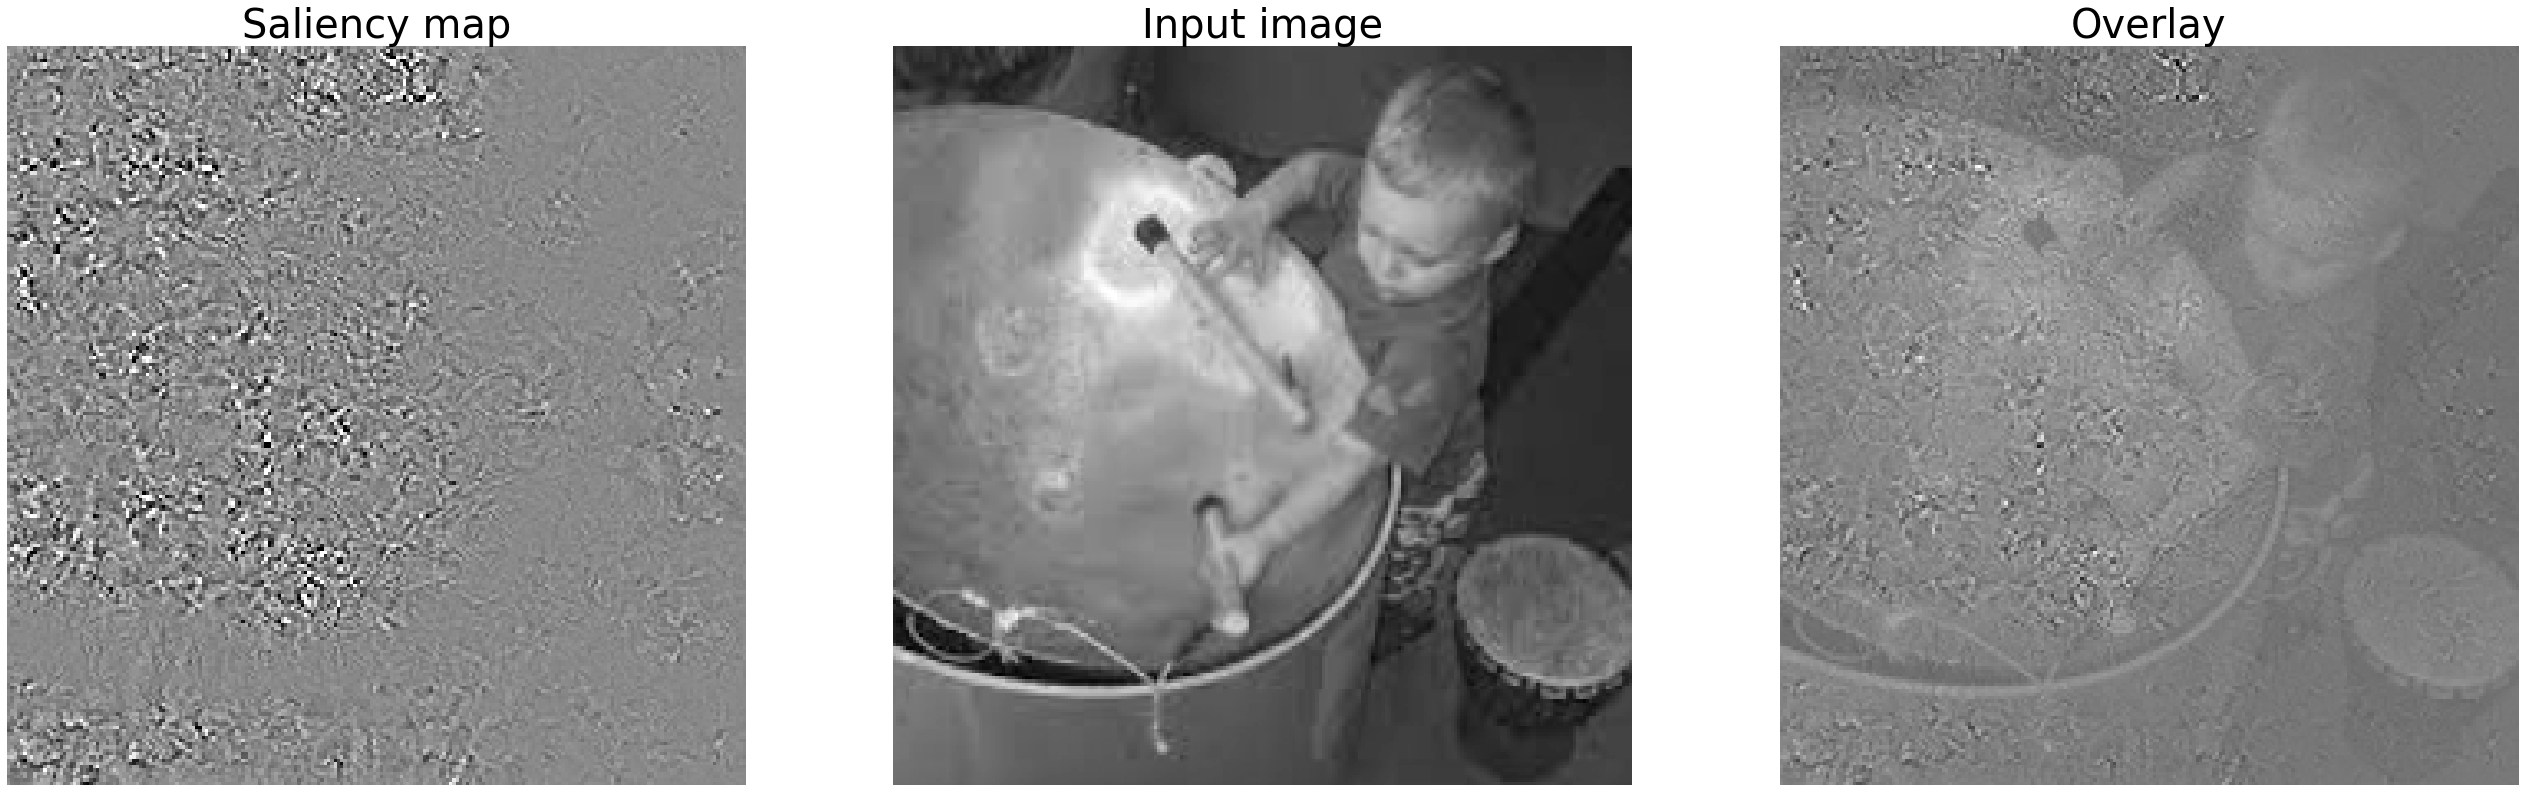


4===========================================================
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627


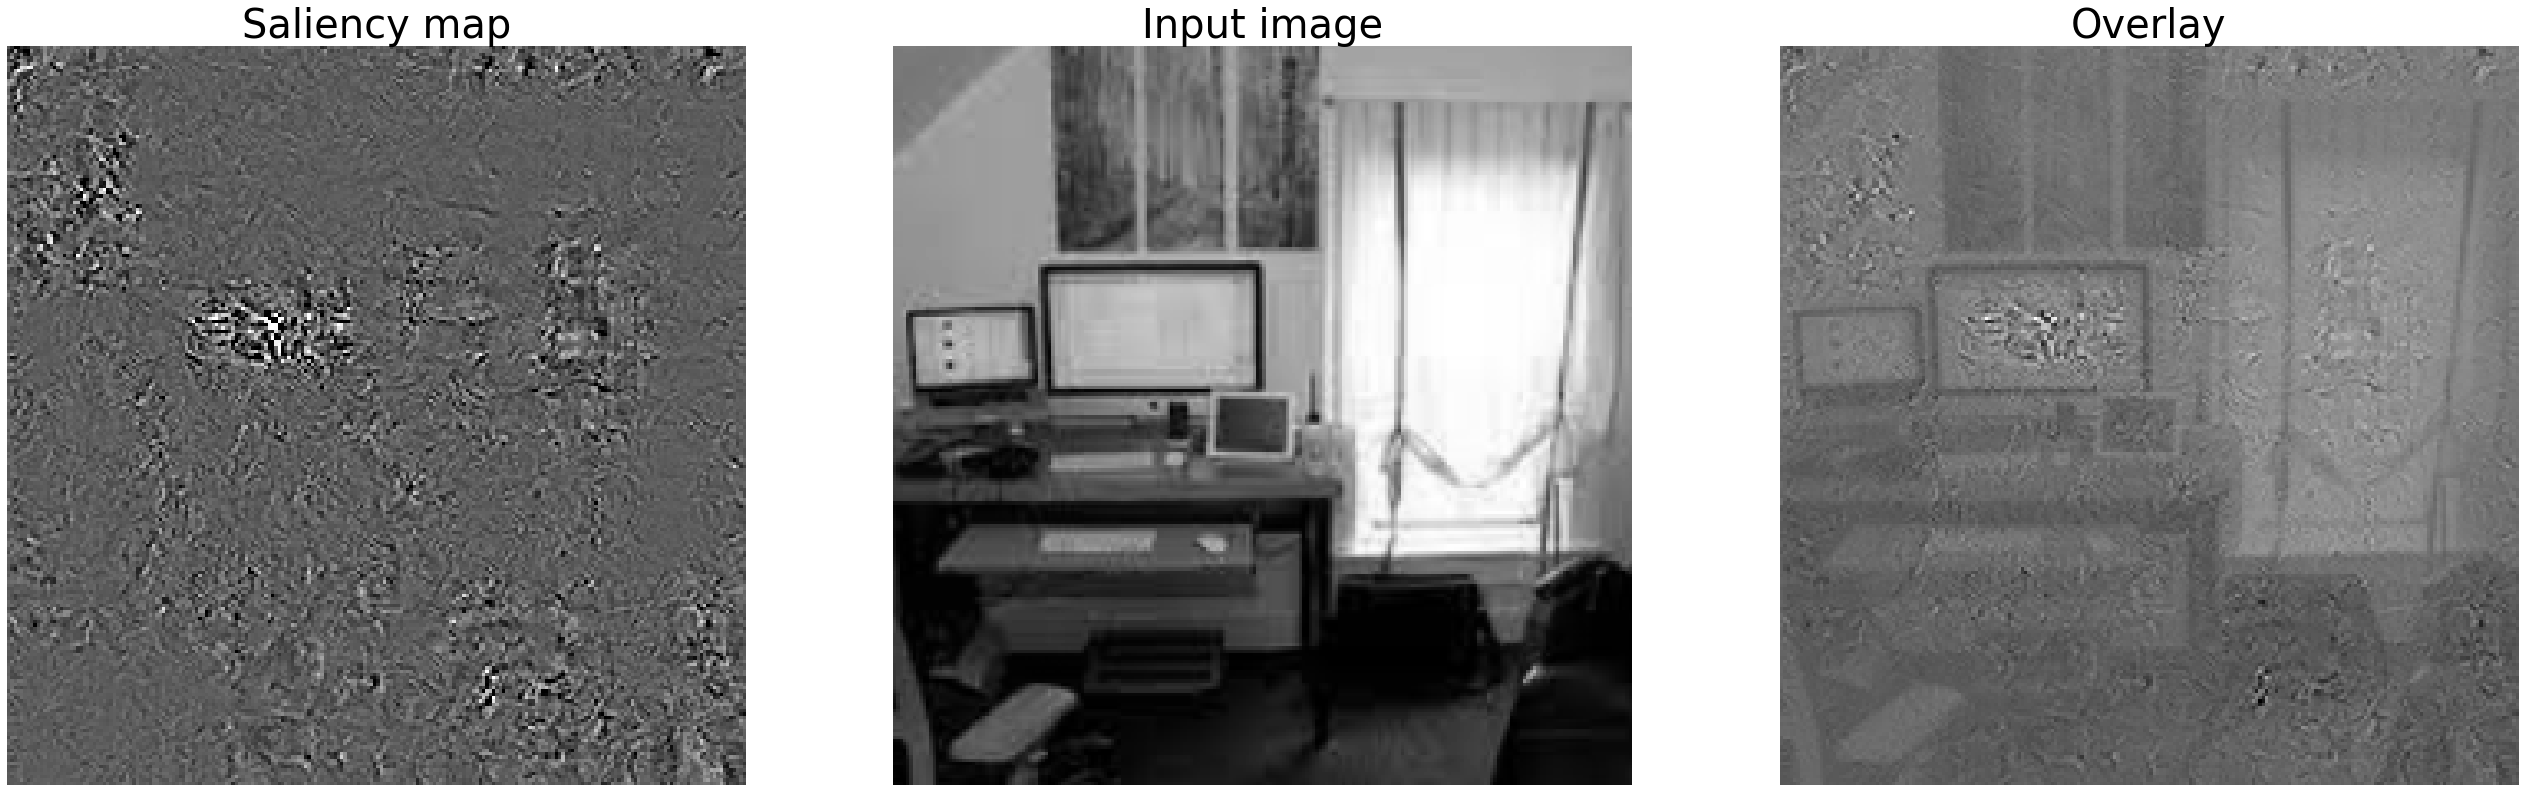


5===========================================================
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351


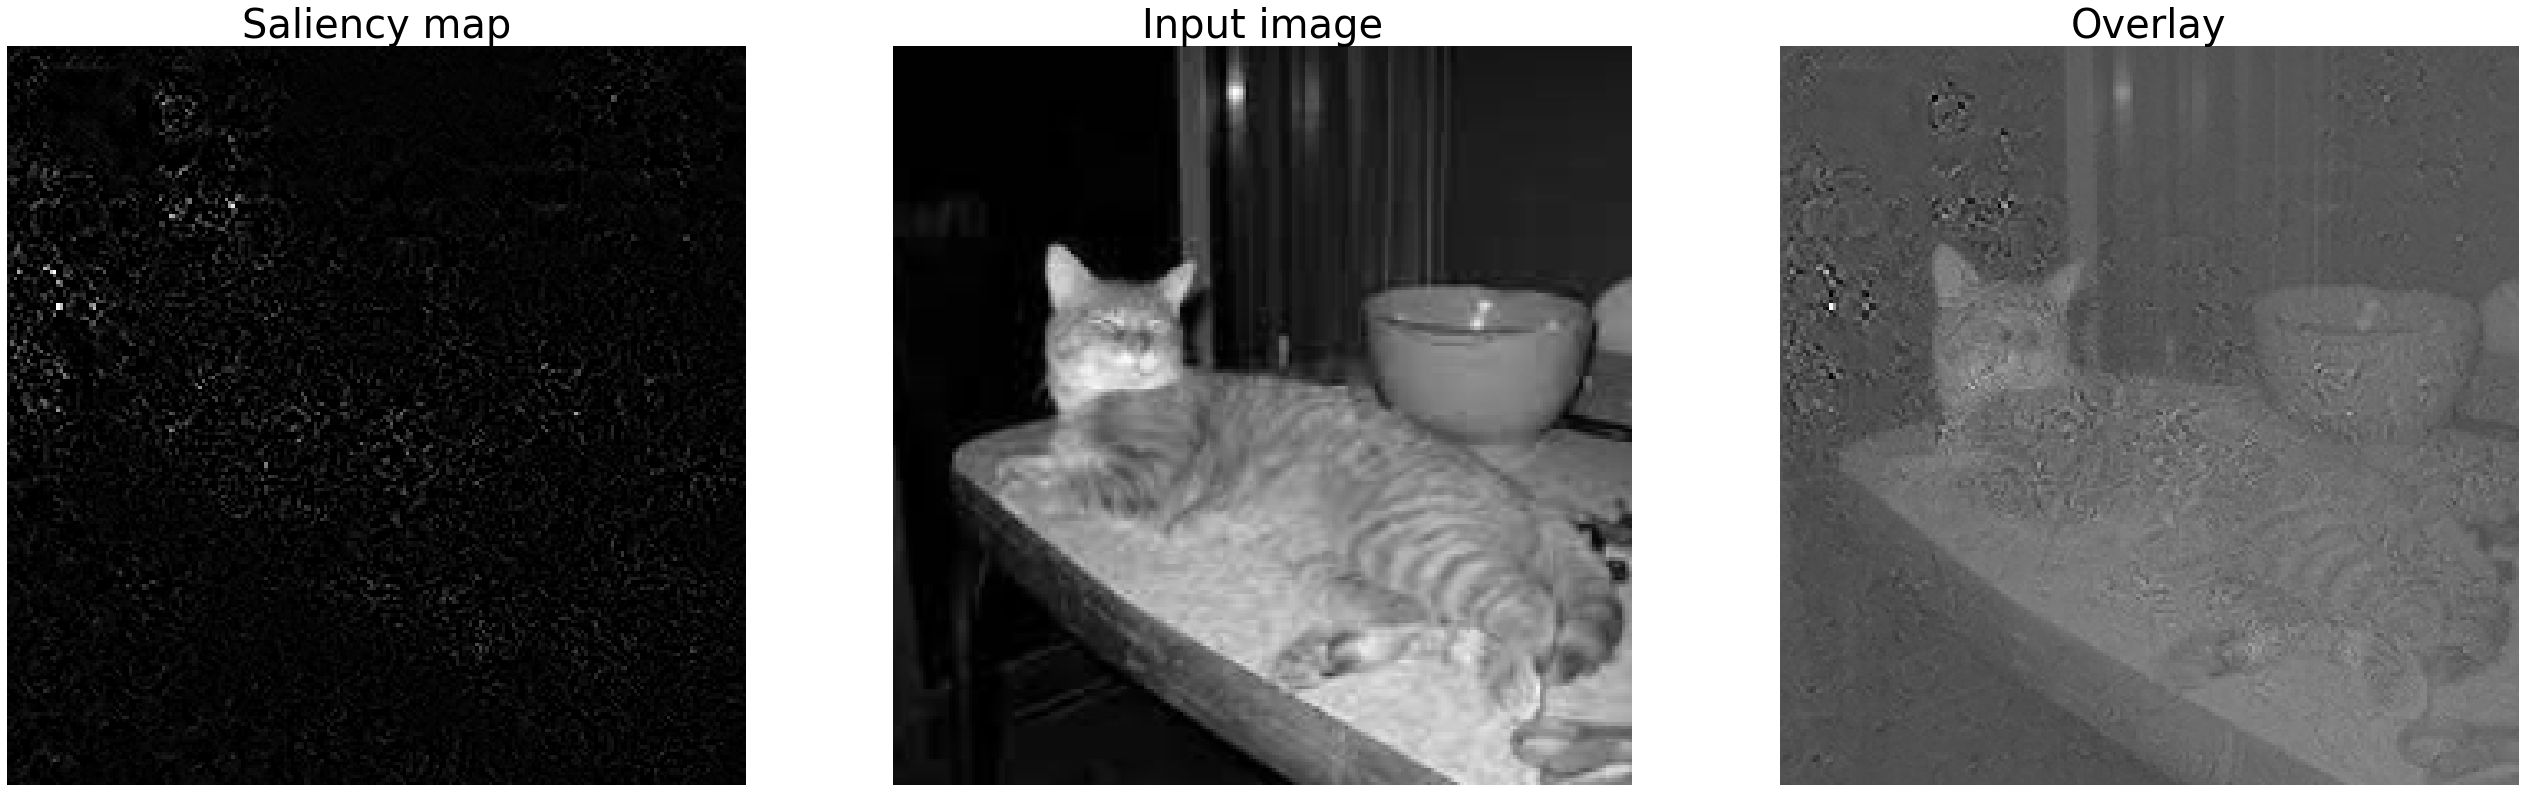

In [ ]:
for i, path in enumerate(paths):
  print(f"{i+1}===========================================================")
  vanilla_backprop(path)
  print()

1===========================================================
German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197


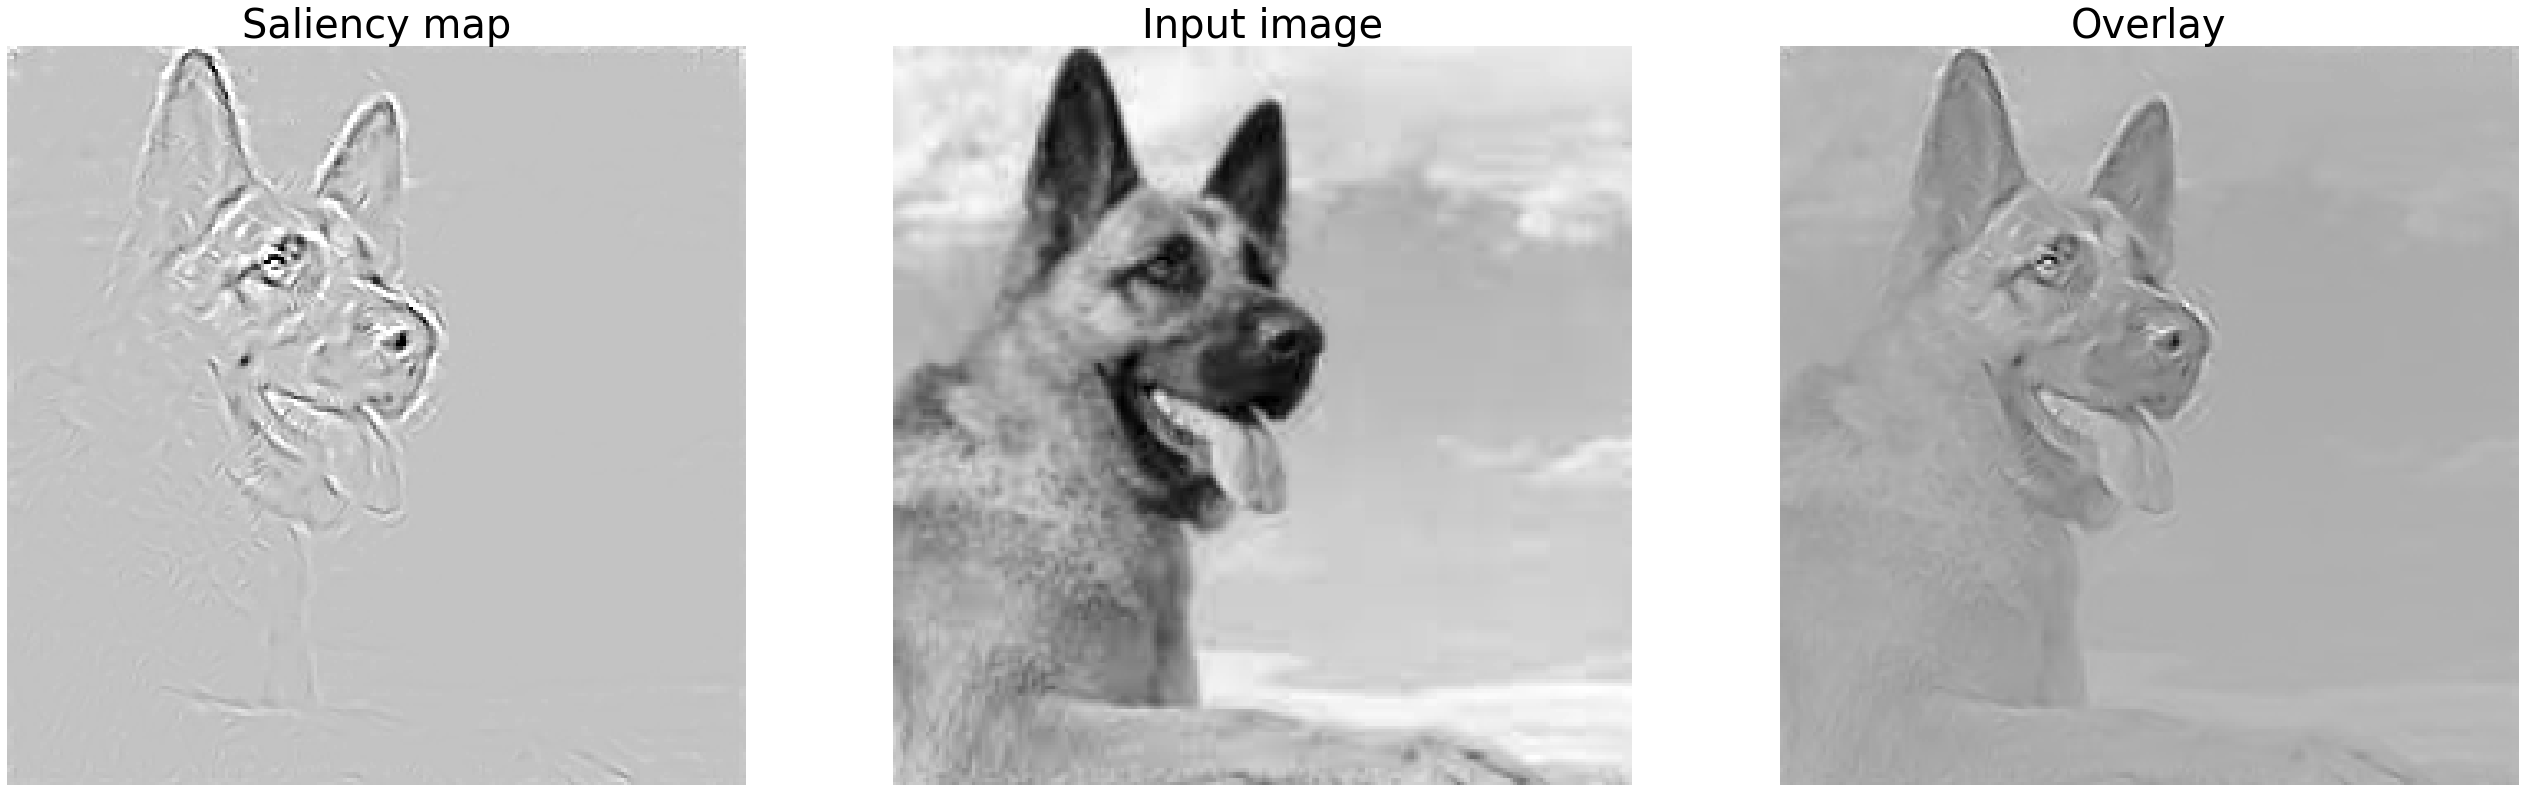


2===========================================================
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755


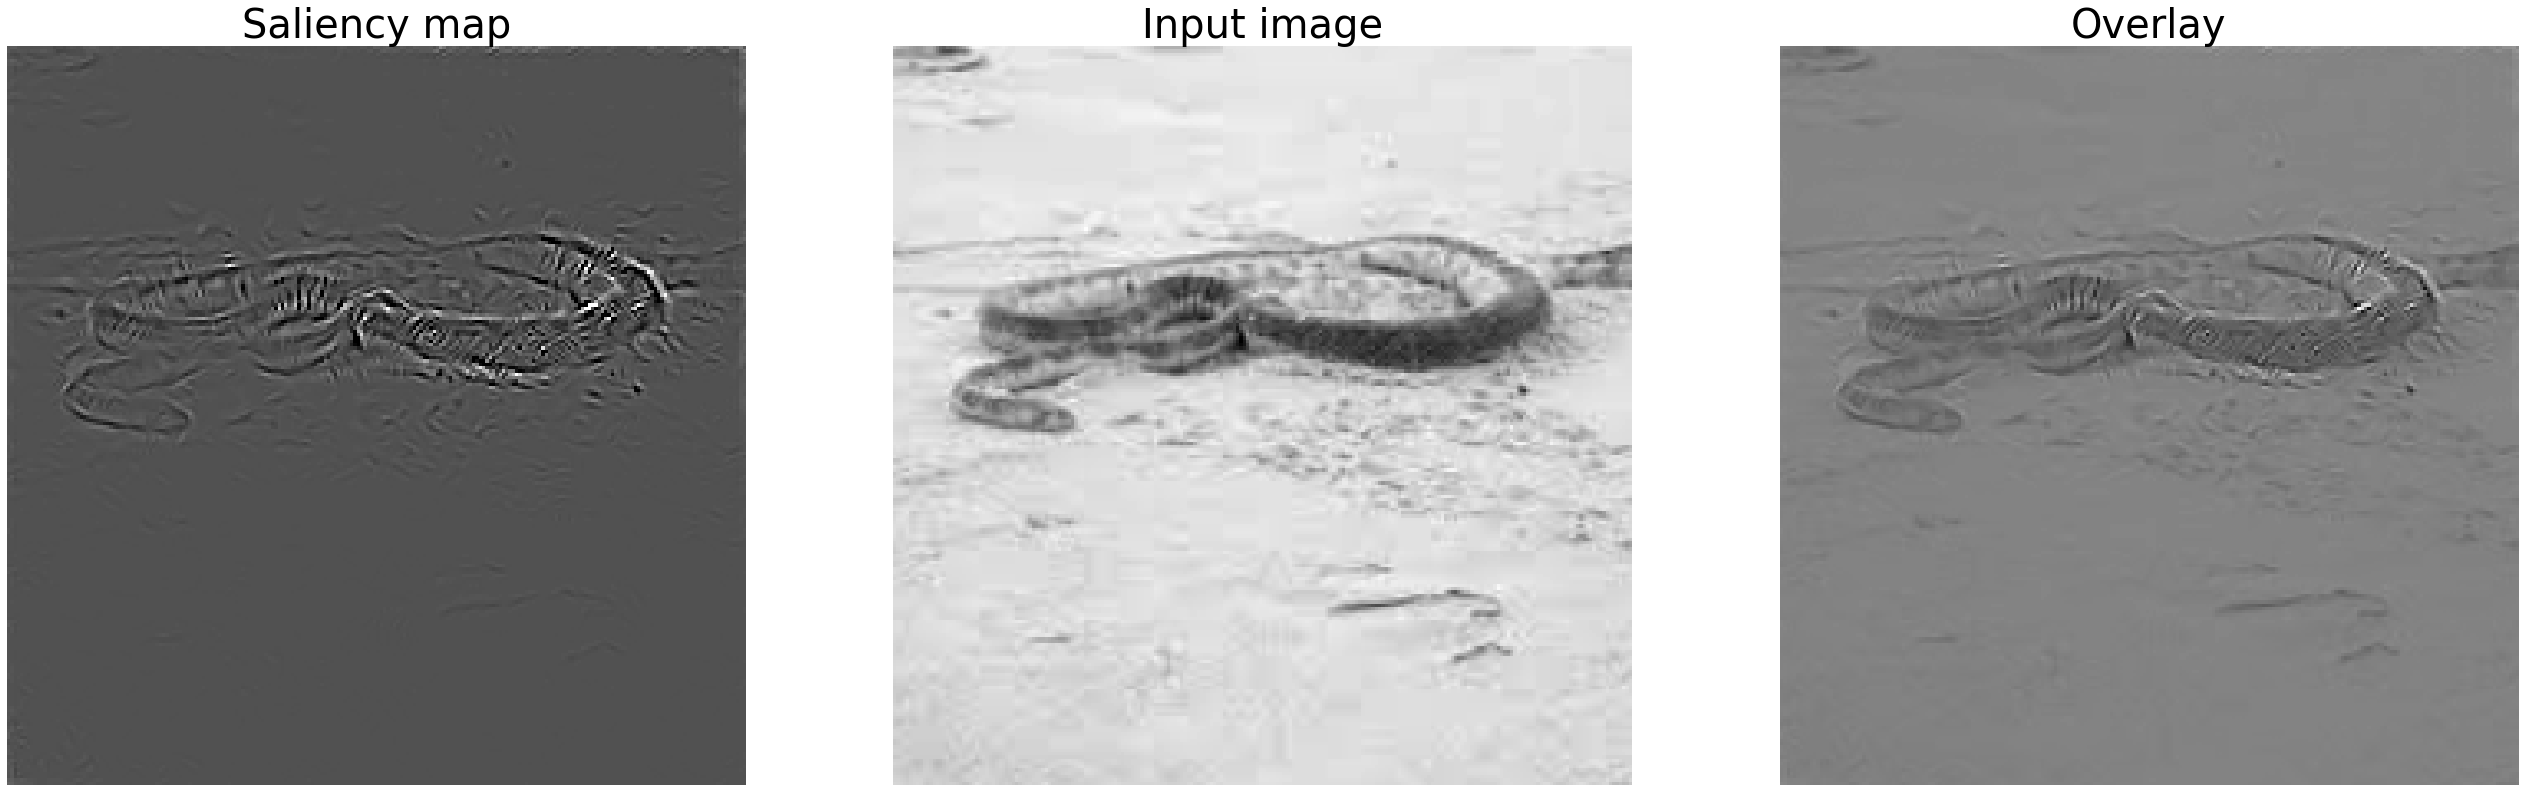


3===========================================================
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946


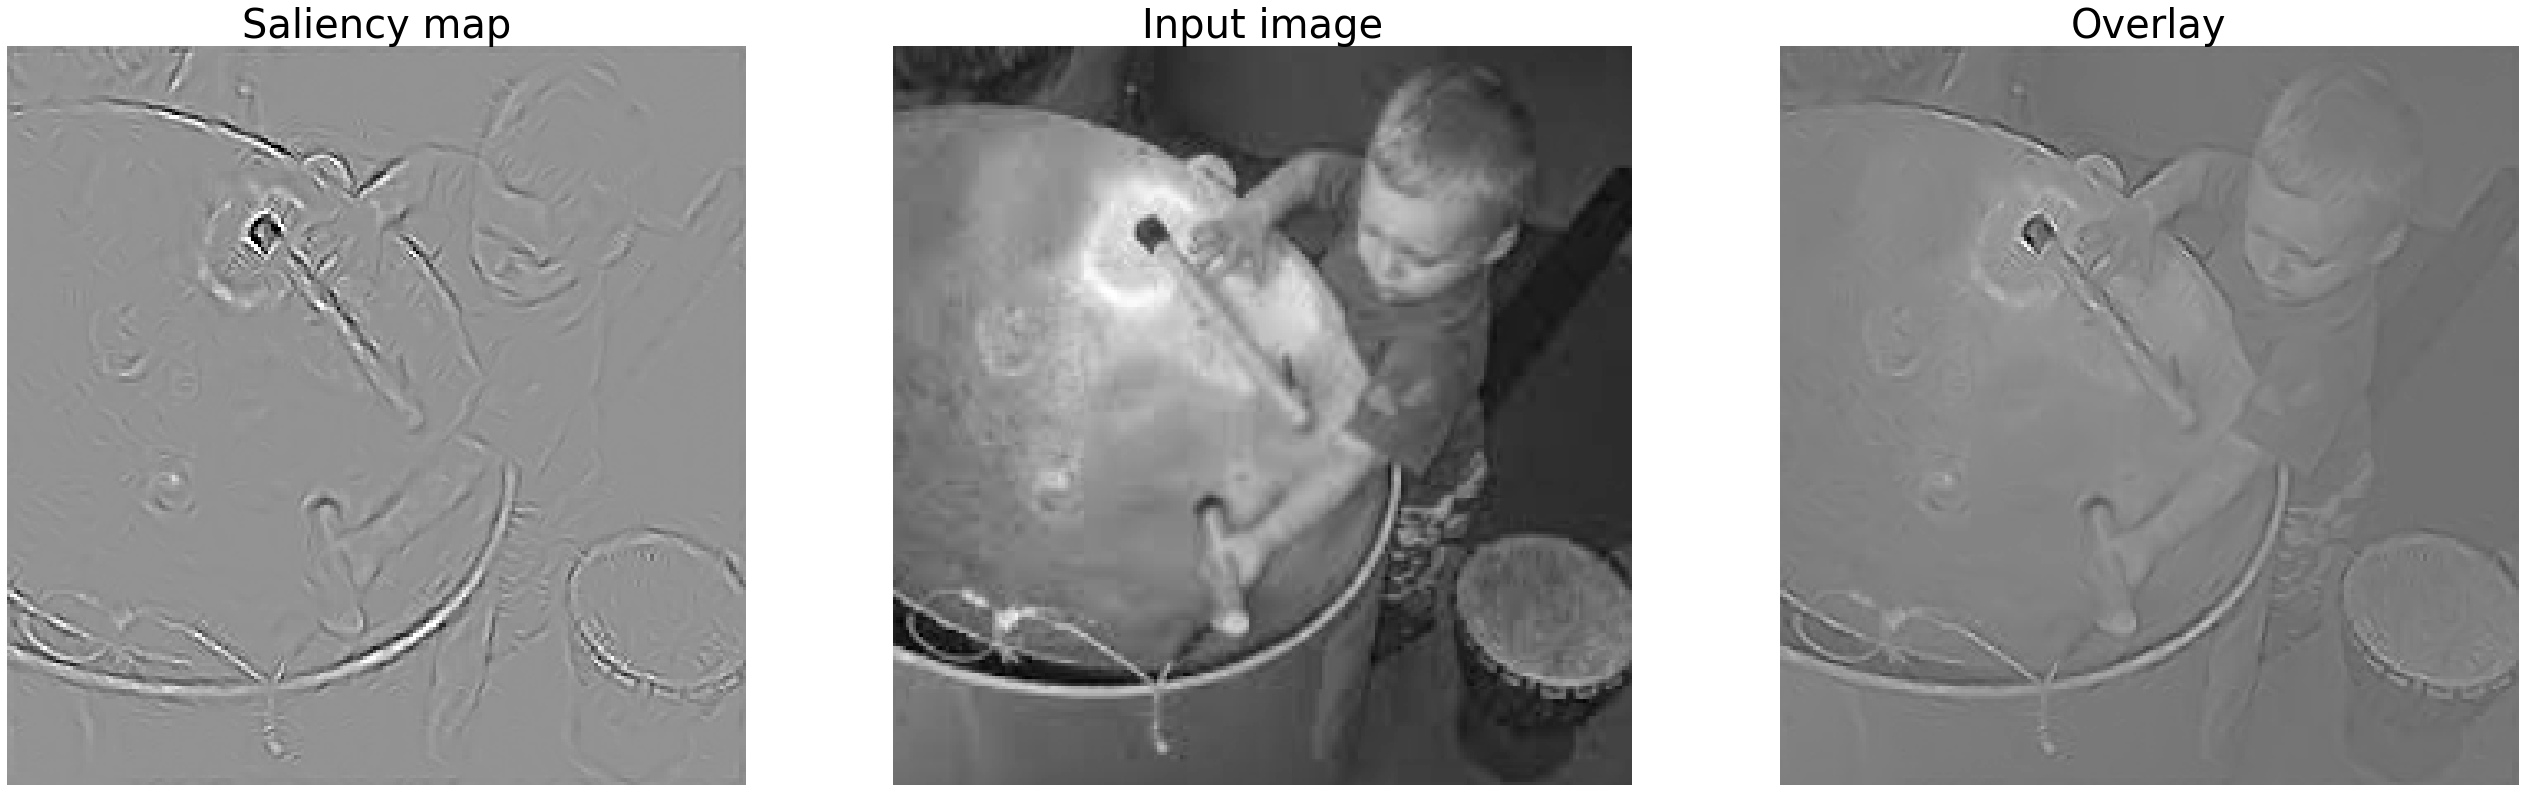


4===========================================================
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627


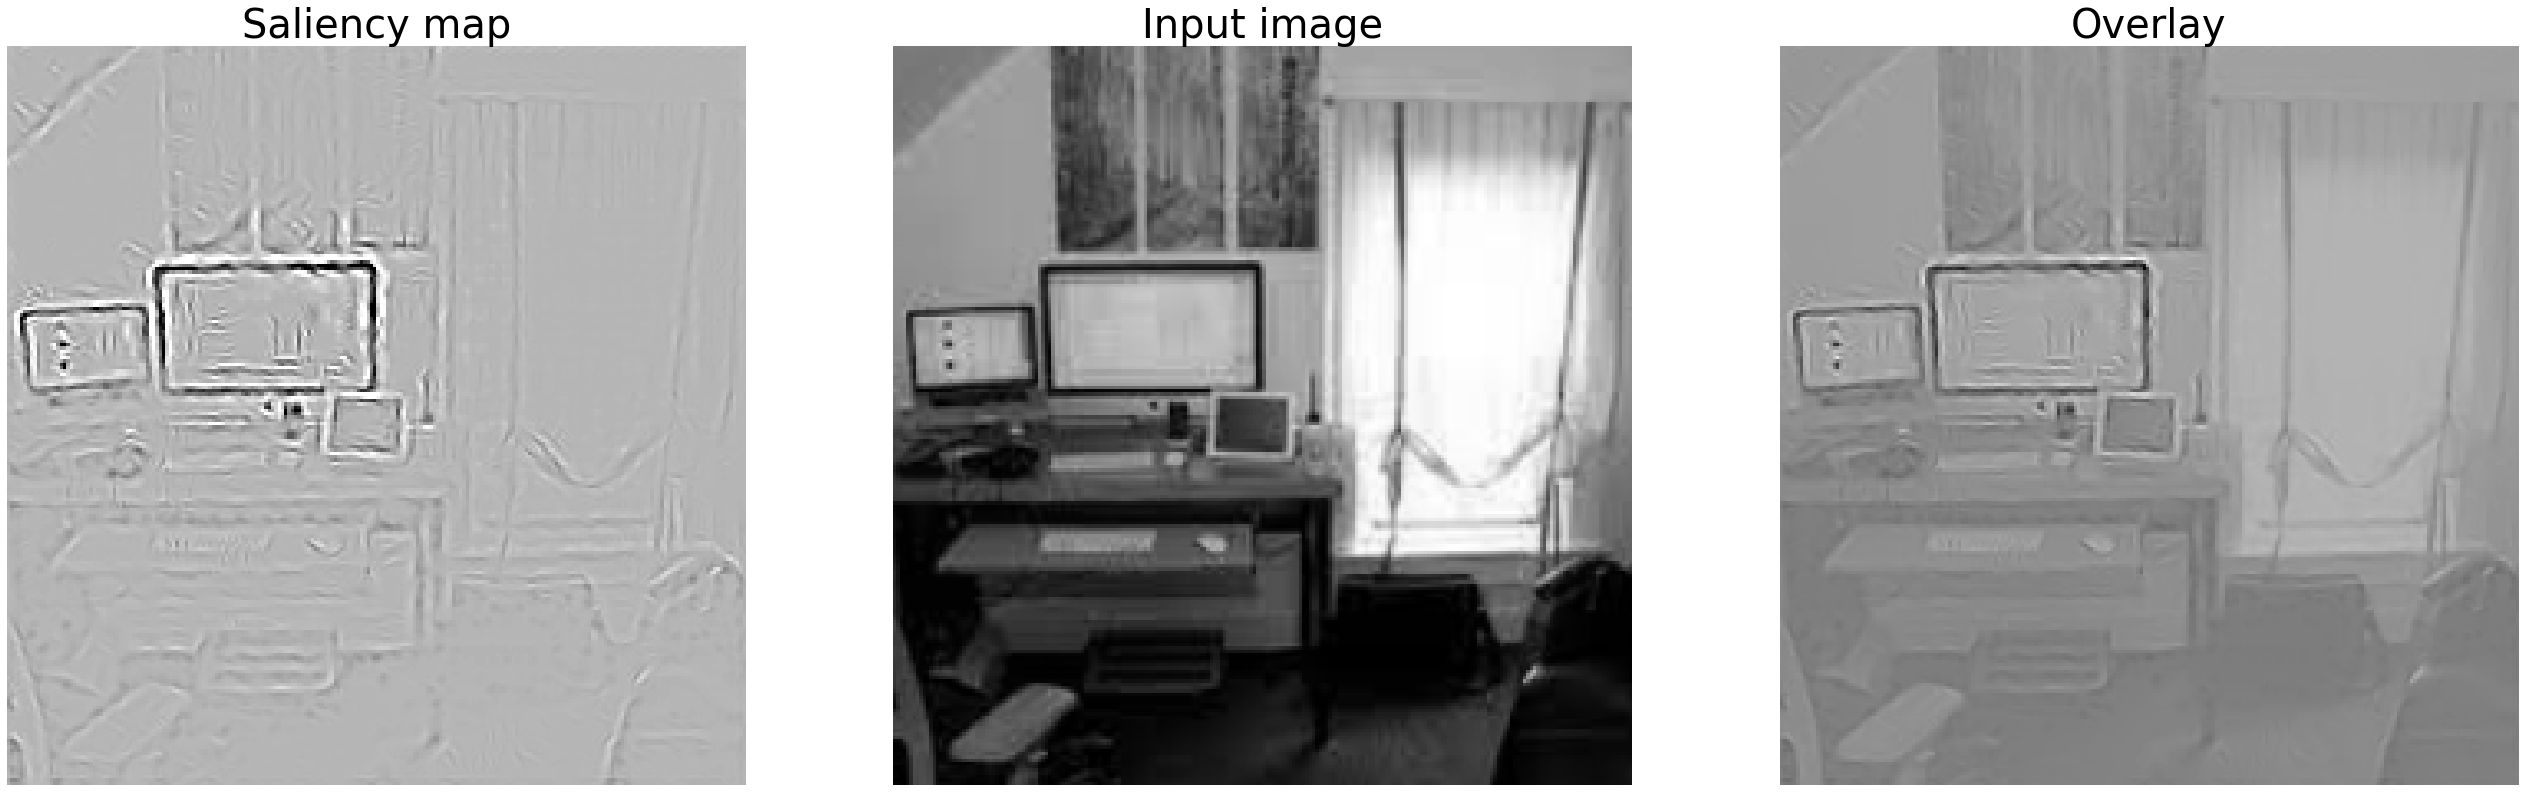


5===========================================================
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351


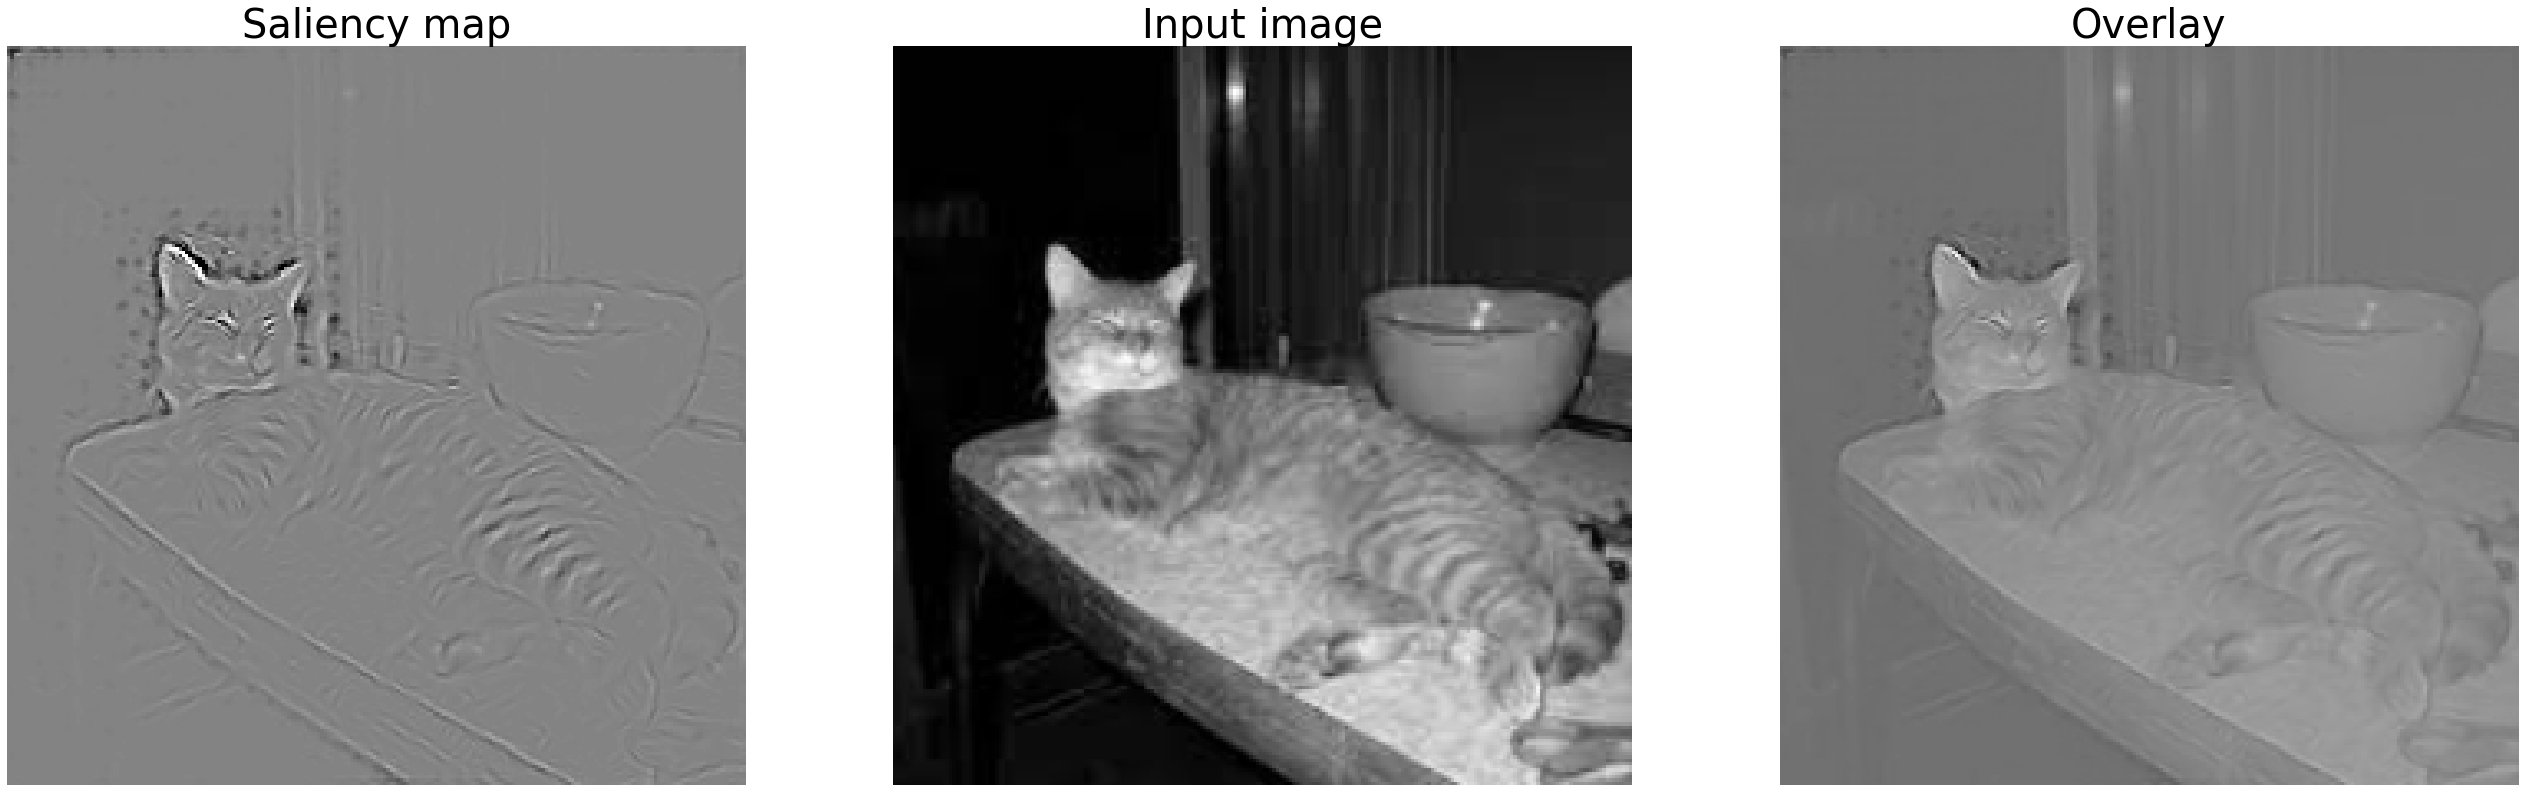

In [ ]:
for i, path in enumerate(paths):
  print(f"{i+1}===========================================================")
  _ = guided_backprop(path)
  print()

1===========================================================
German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197


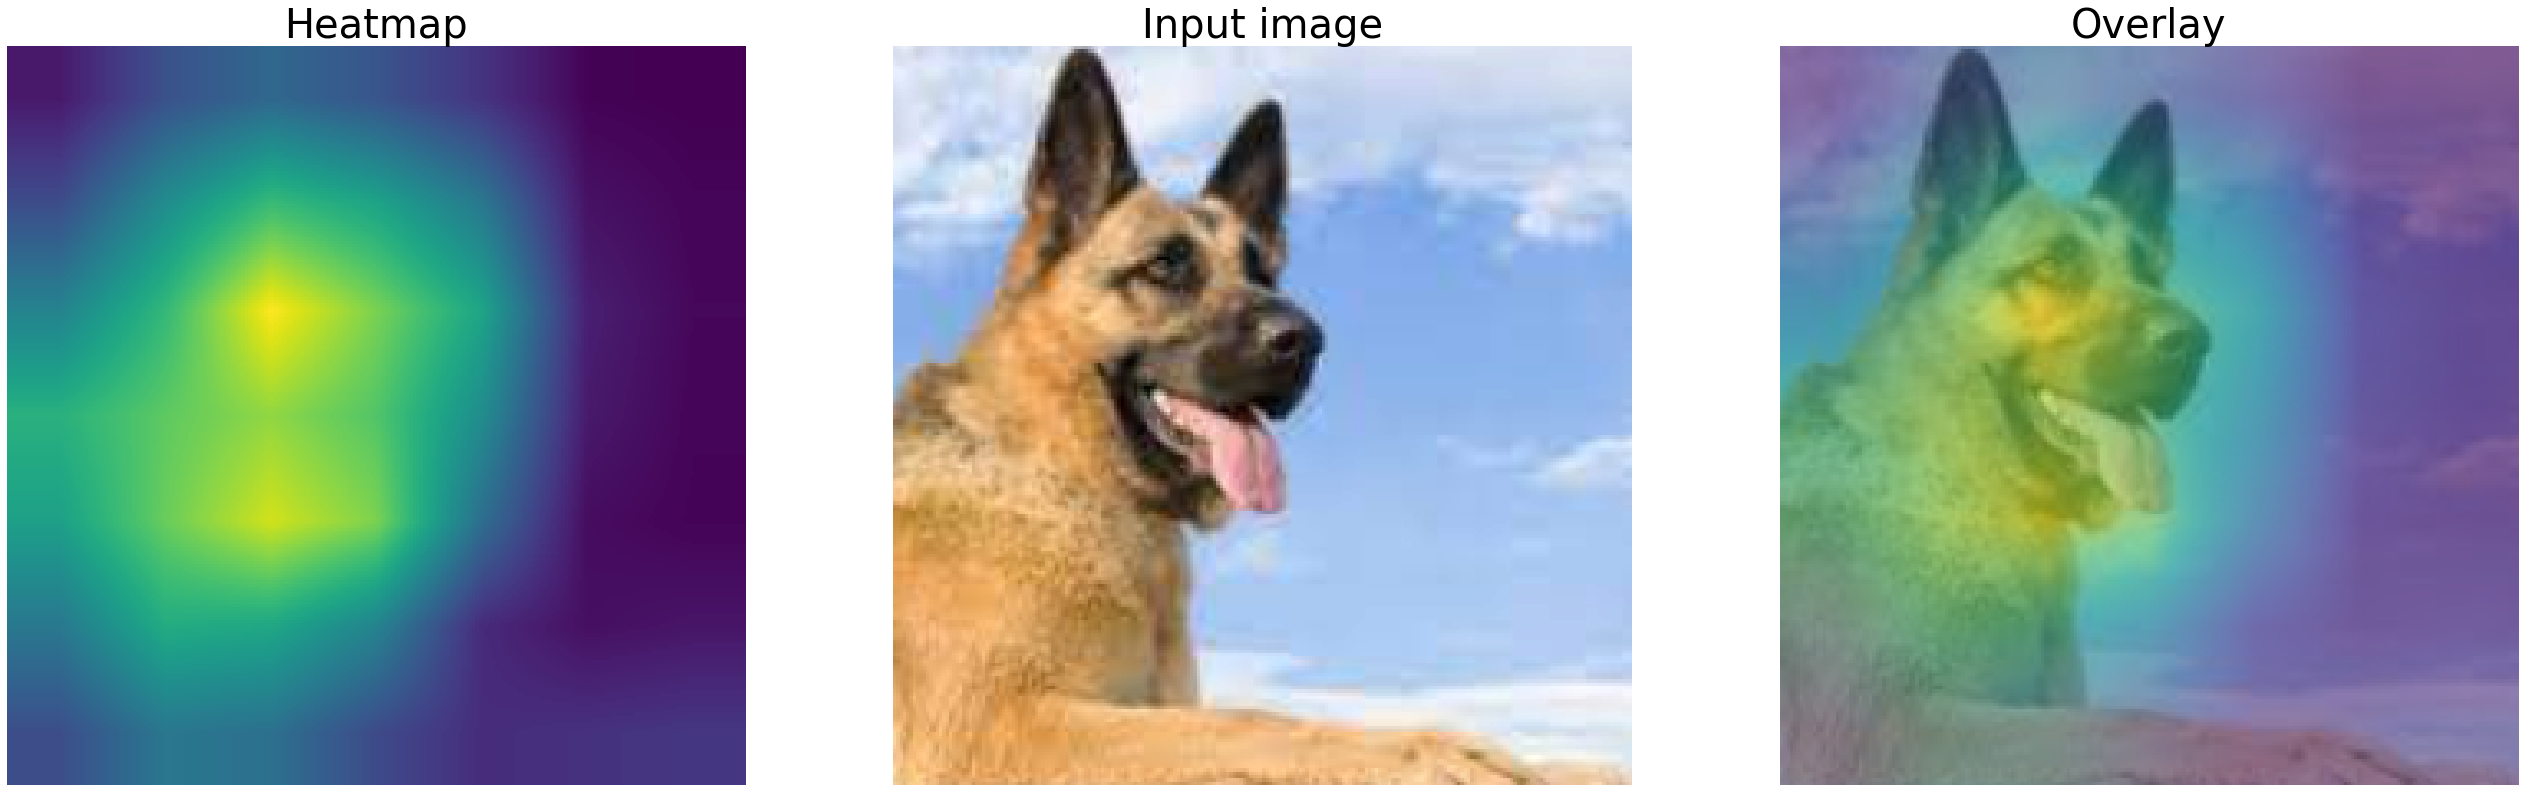


2===========================================================
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755


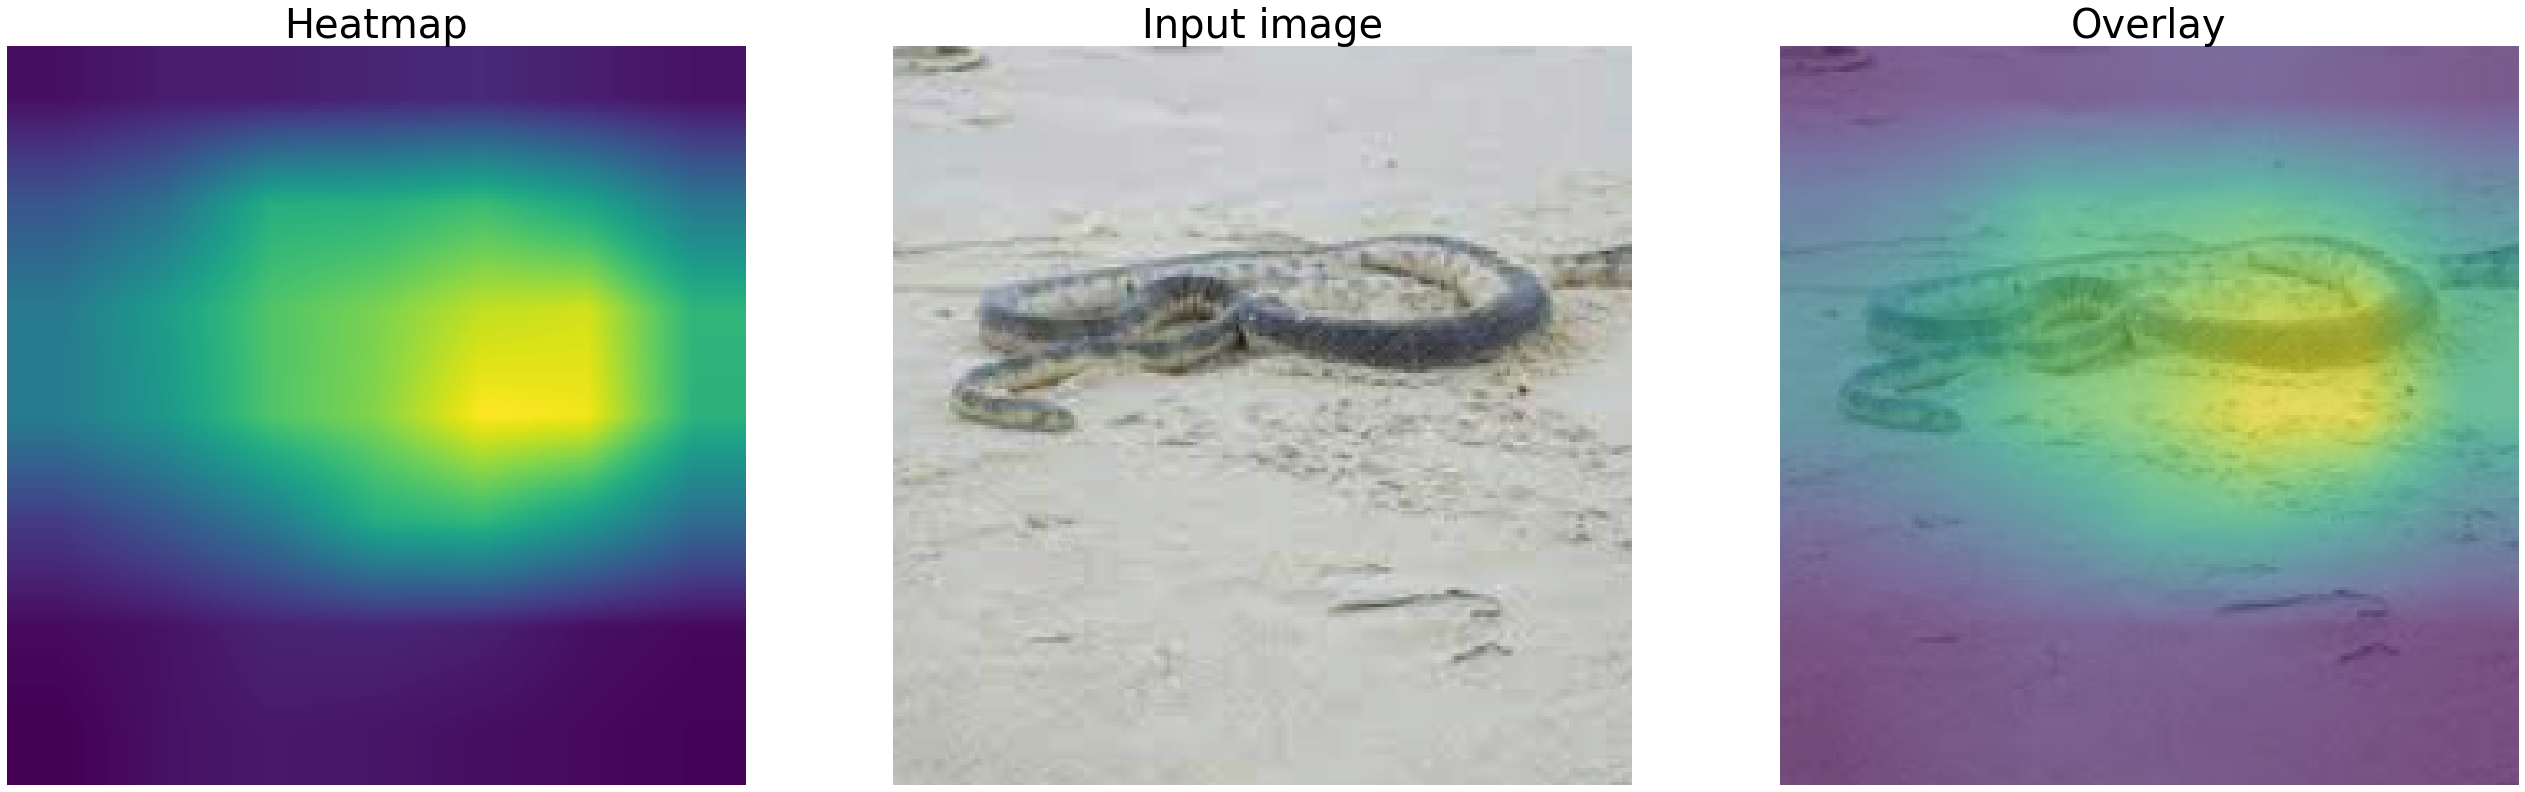


3===========================================================
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946


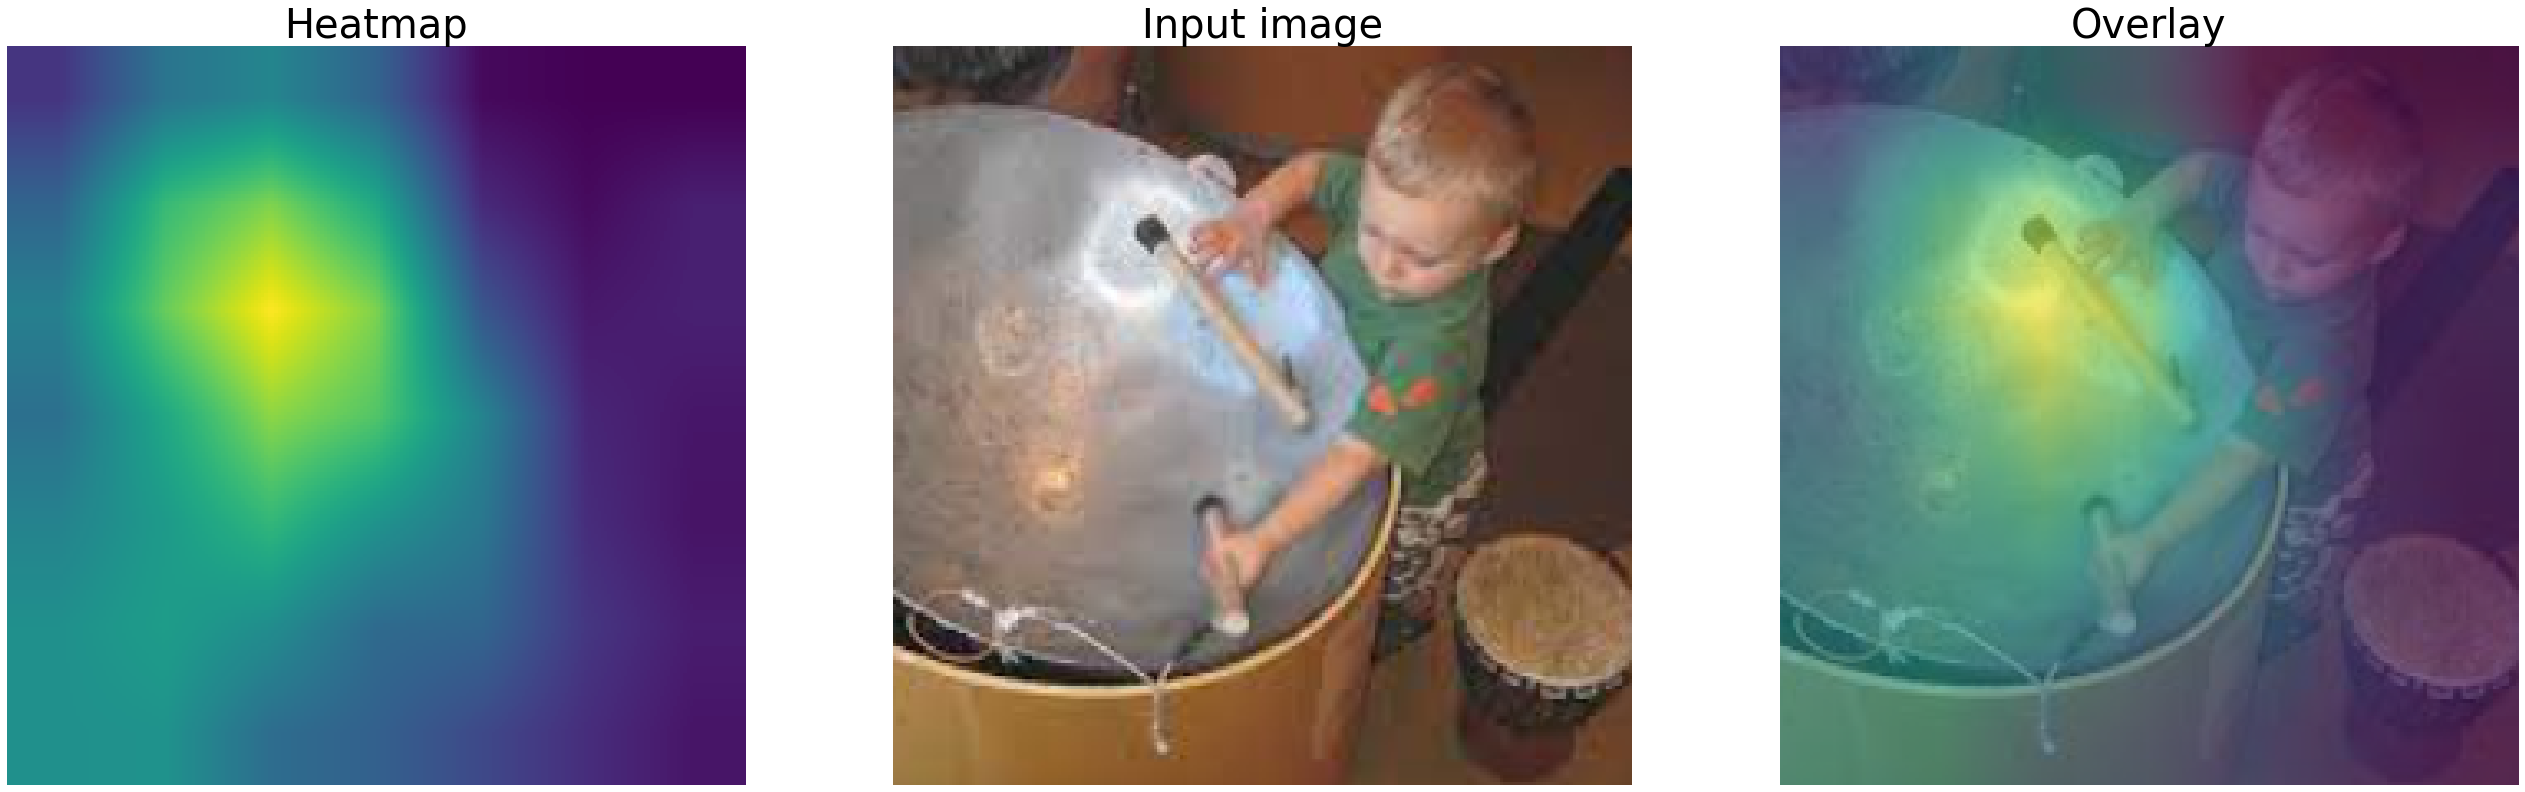


4===========================================================
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627


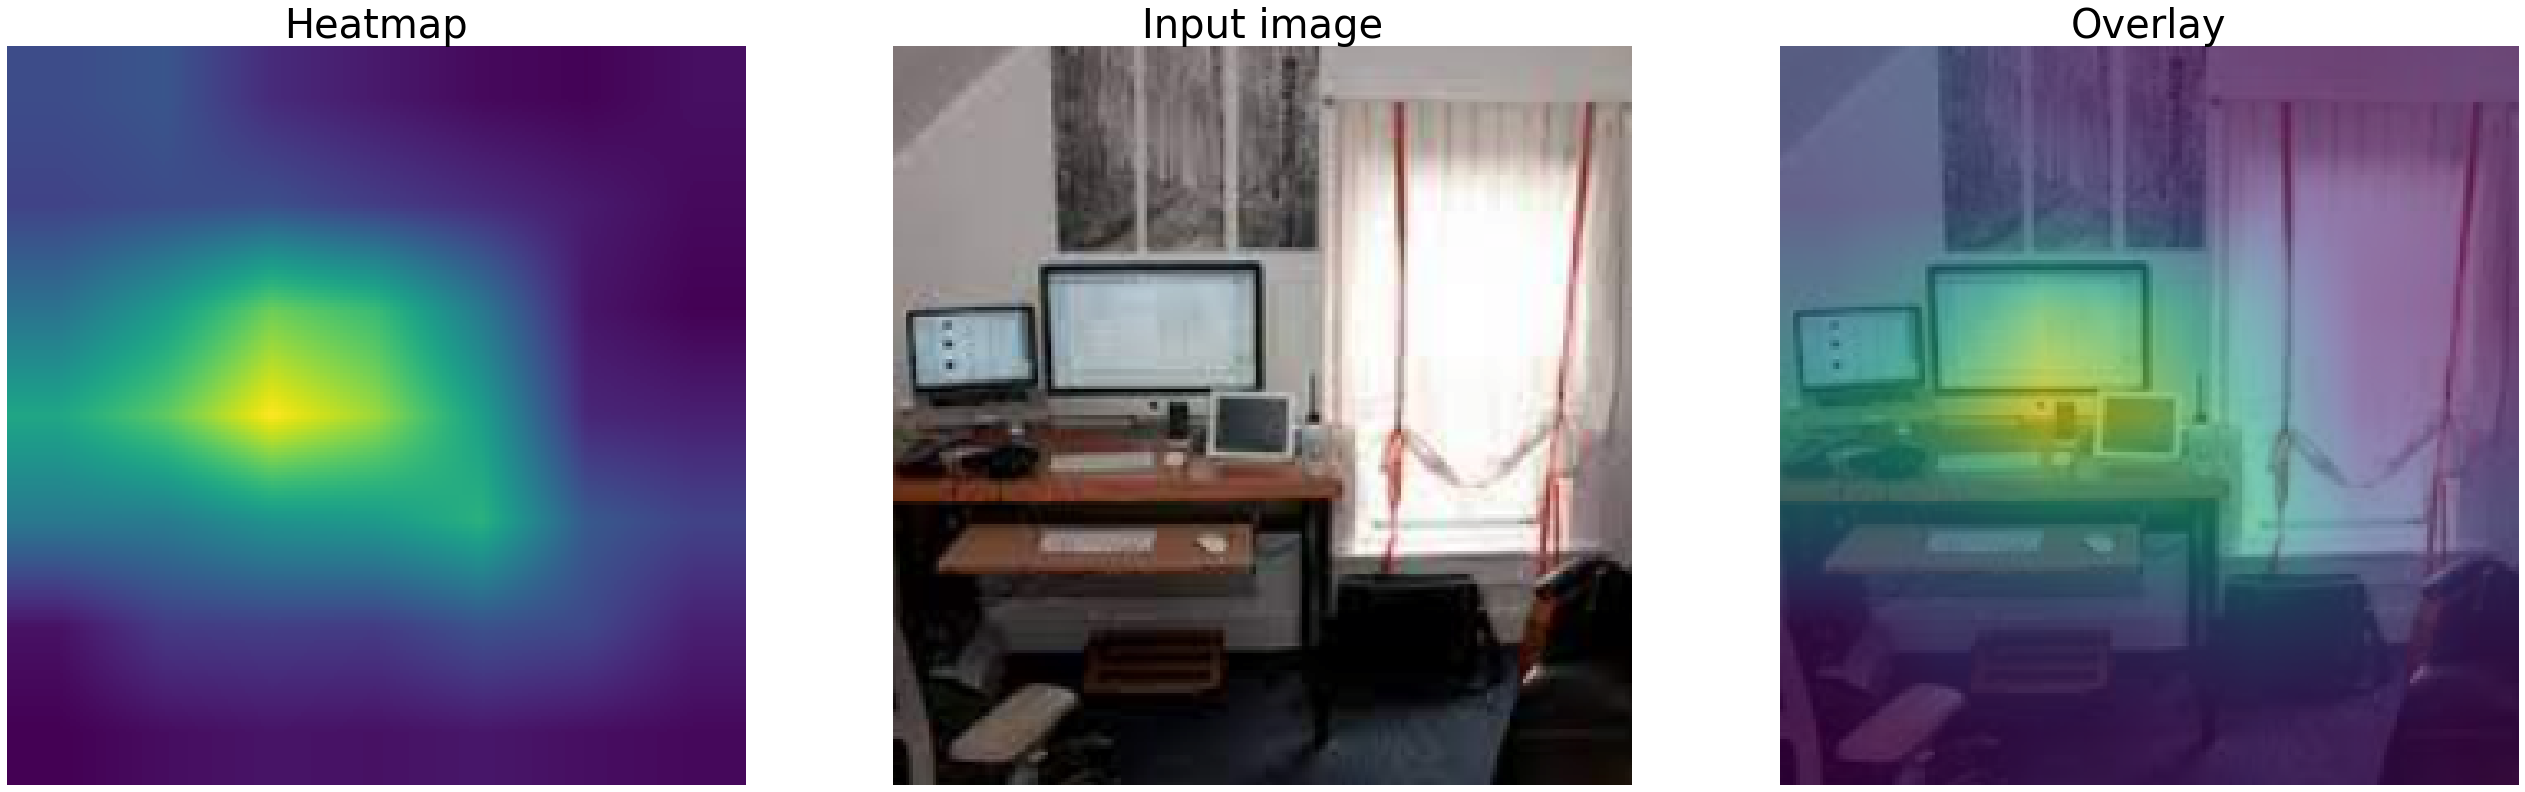


5===========================================================
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351


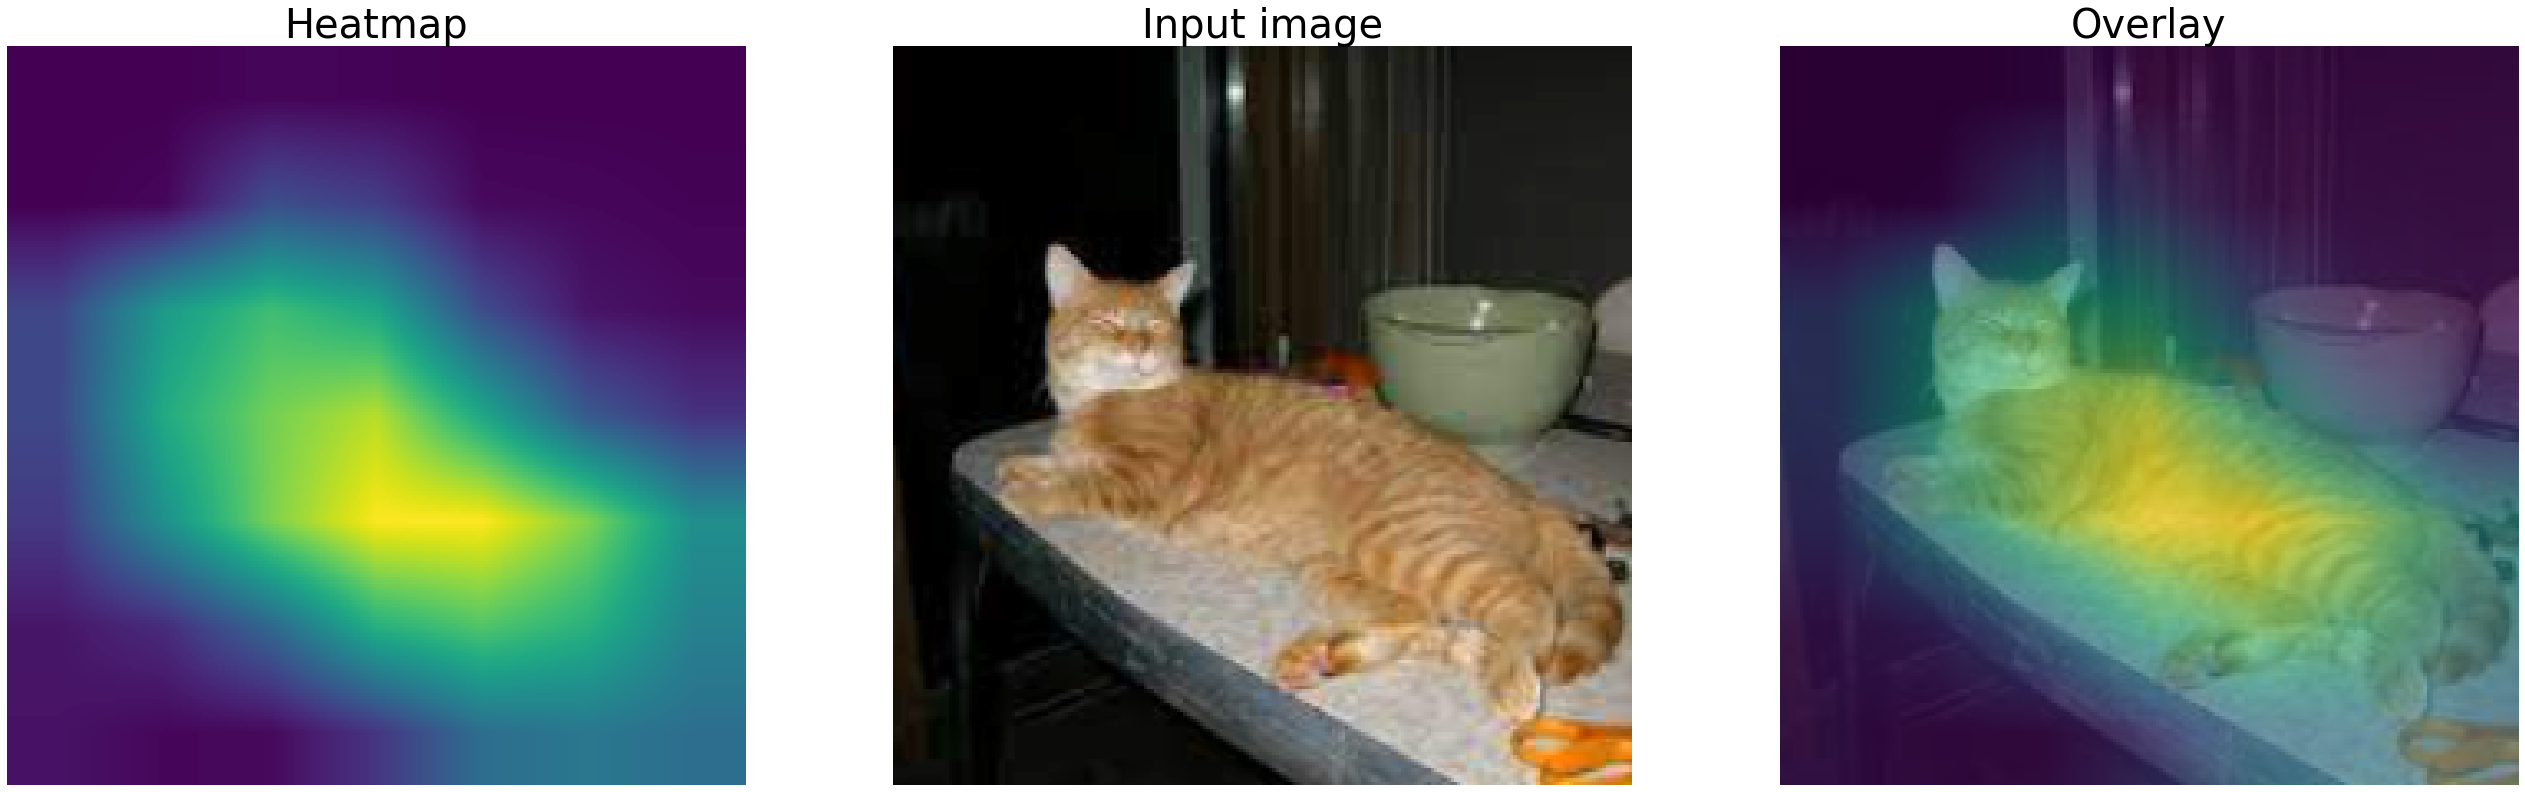

In [ ]:
for i, path in enumerate(paths):
  print(f"{i+1}===========================================================")
  class_activation_map(path)
  print()

In [ ]:
grads = None
acts = None

def grad_hook(module, grad_in, grad_out):
  global grads
  if grads is None:
    grads = grad_out[0].detach()

def act_hook(module, inp, out):
  global acts
  acts = out.detach()

def grad_cam(path):
  global grads
  global acts
  img = prep_input(path)
  img.requires_grad = True
  model = torchvision.models.resnet50(True)
  model.eval()
  model.layer4[2].conv3.register_backward_hook(grad_hook)
  model.layer4[2].conv3.register_forward_hook(act_hook)
  output = model(img)
  predicted_class = output.argmax()
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  top5_probabilities, top5_classes = torch.topk(probabilities, 5)
  for i in range(5):
    print(categories[top5_classes[i]], top5_probabilities[i].item())
  model.zero_grad()
  one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float32)
  one_hot[0][predicted_class] = 1
  output.backward(gradient=one_hot)
  weights = torch.mean(grads, dim=(2, 3), keepdim=True)
  cam = torch.sum(weights * acts, dim=1, keepdim=True)
  cam = torch.nn.functional.relu(cam)
  cam = (cam - torch.min(cam))/ (torch.max(cam) - torch.min(cam))

  cam = cam[0]
  resize = torchvision.transforms.Resize(224)
  cam = resize(cam)
  cam = cam[0]
  cmap = plt.colormaps.get_cmap('viridis')
  heatmap = cmap(cam.detach())[:, :, :3]
  # plt.imshow(heatmap)
  # plt.show()
  img = prep_output(img)
  # plt.imshow((heatmap * 0.6) + (img * 0.4))
  # plt.show()
  grads = None
  acts = None

  return cam.detach().numpy()

In [ ]:
def plot_guided_grad_cam(heatmap, grads, res):
  fig, axes = plt.subplots(1, 4)
  fig.set_figheight(20)
  fig.set_figwidth(45)
  axes[0].imshow(PIL.Image.open(path))
  axes[0].axis('off')
  axes[0].set_title('Input image', fontsize=40)
  axes[1].imshow(grads, cmap="gray")
  axes[1].axis('off')
  axes[1].set_title('Guided backpropagation', fontsize=40)
  axes[2].imshow(heatmap)
  axes[2].axis('off')
  axes[2].set_title('Grad-CAM', fontsize=40)
  axes[3].imshow(res, cmap="gray")
  axes[3].axis('off')
  axes[3].set_title('Guided Grad-CAM', fontsize=40)
  plt.show()
  print()

1===========================================================
German shepherd 0.5617912411689758
malinois 0.3023851811885834
Norwegian elkhound 0.0334751233458519
kelpie 0.028492506593465805
dingo 0.017275135964155197


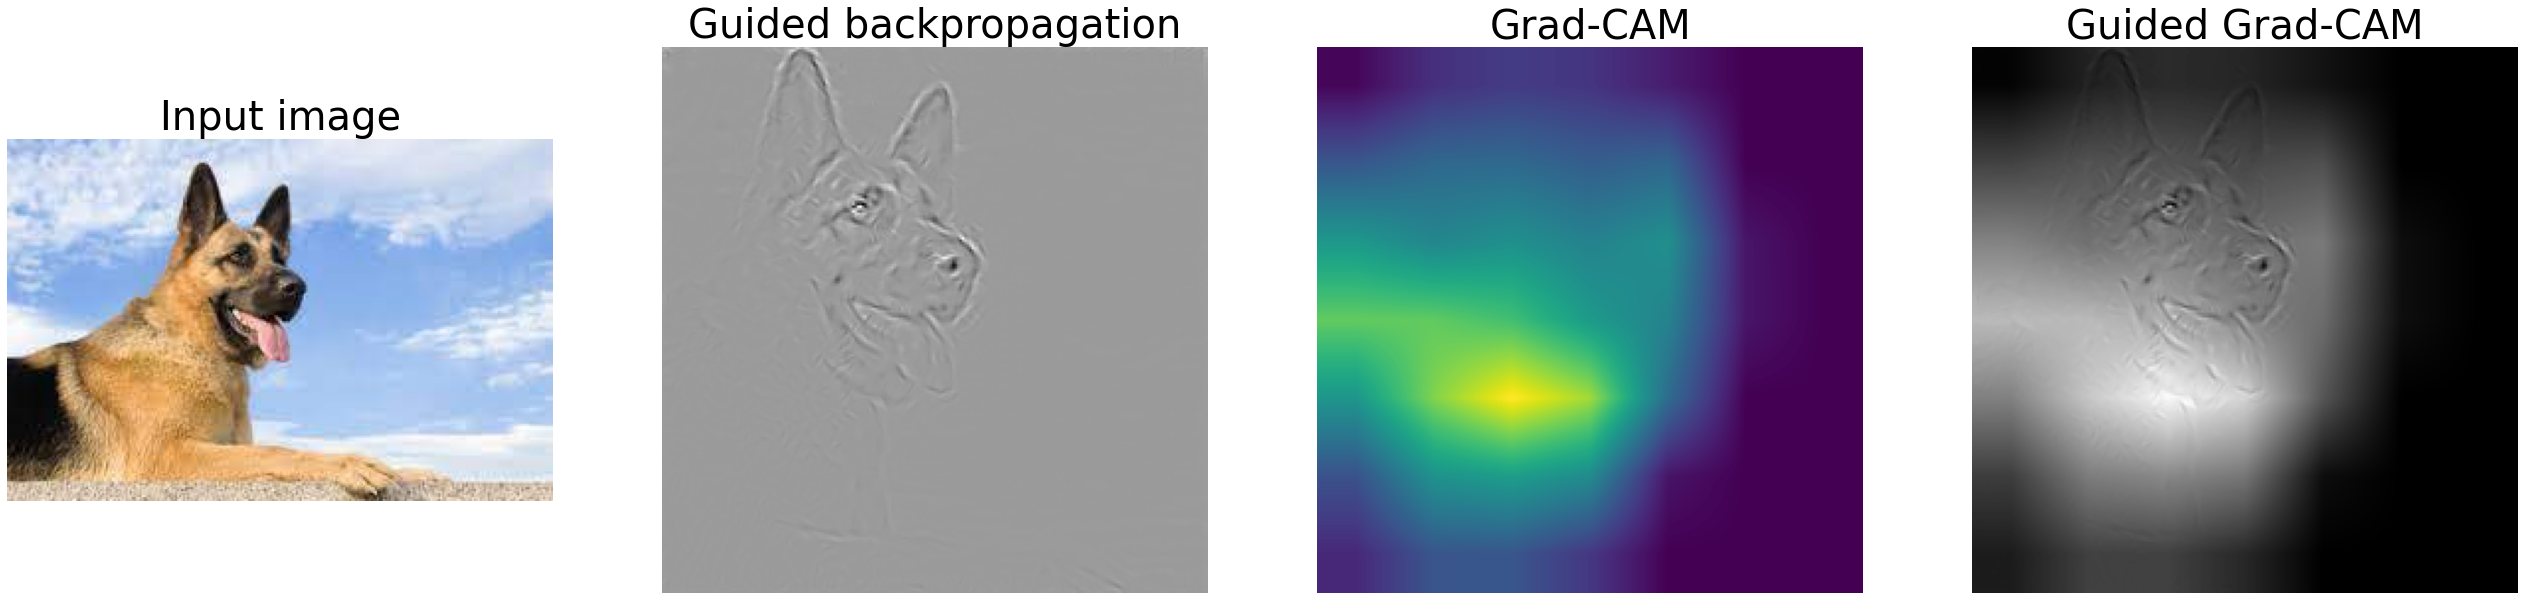

In [ ]:
path = paths[0]
print("1===========================================================")
heatmap = grad_cam(path)
grads = guided_backprop(path, info=False)
res = np.multiply(heatmap, grads)
plot_guided_grad_cam(heatmap, grads, res)

2===========================================================
sea snake 0.48247358202934265
water snake 0.20681801438331604
rock python 0.12940376996994019
Indian cobra 0.09965239465236664
sidewinder 0.019358426332473755


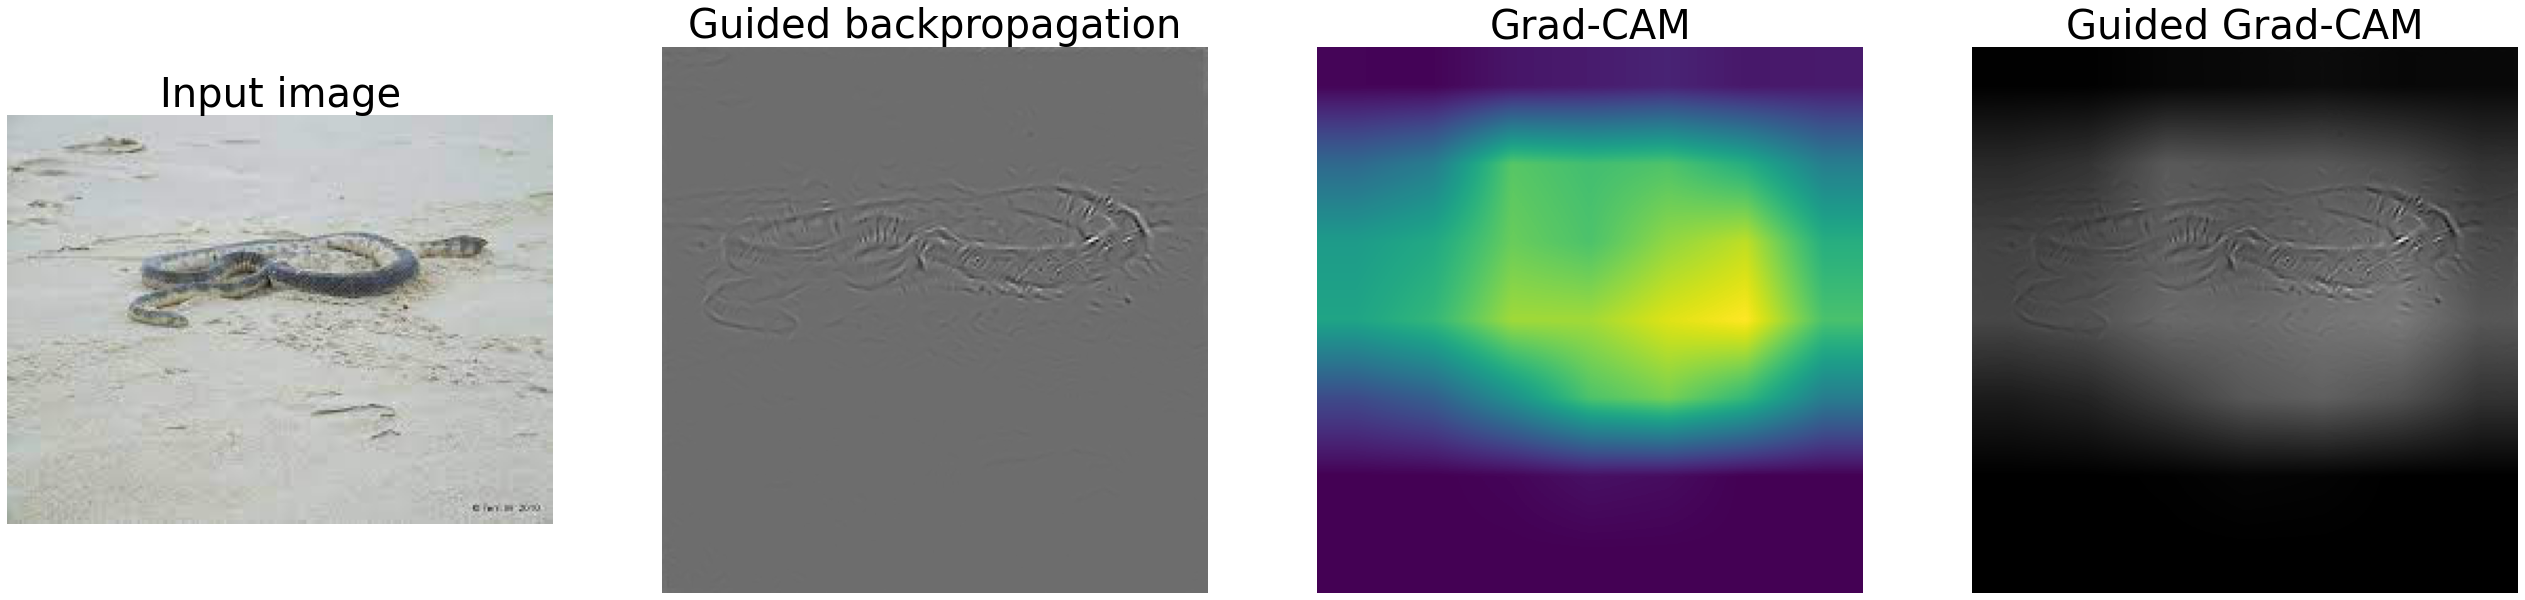

In [ ]:
path = paths[1]
print("2===========================================================")
heatmap = grad_cam(path)
grads = guided_backprop(path, info=False)
res = np.multiply(heatmap, grads)
plot_guided_grad_cam(heatmap, grads, res)

3===========================================================
steel drum 0.9946337938308716
drum 0.0021236068569123745
caldron 0.0019631185568869114
barrel 0.0003869268111884594
gong 0.00025428380467928946


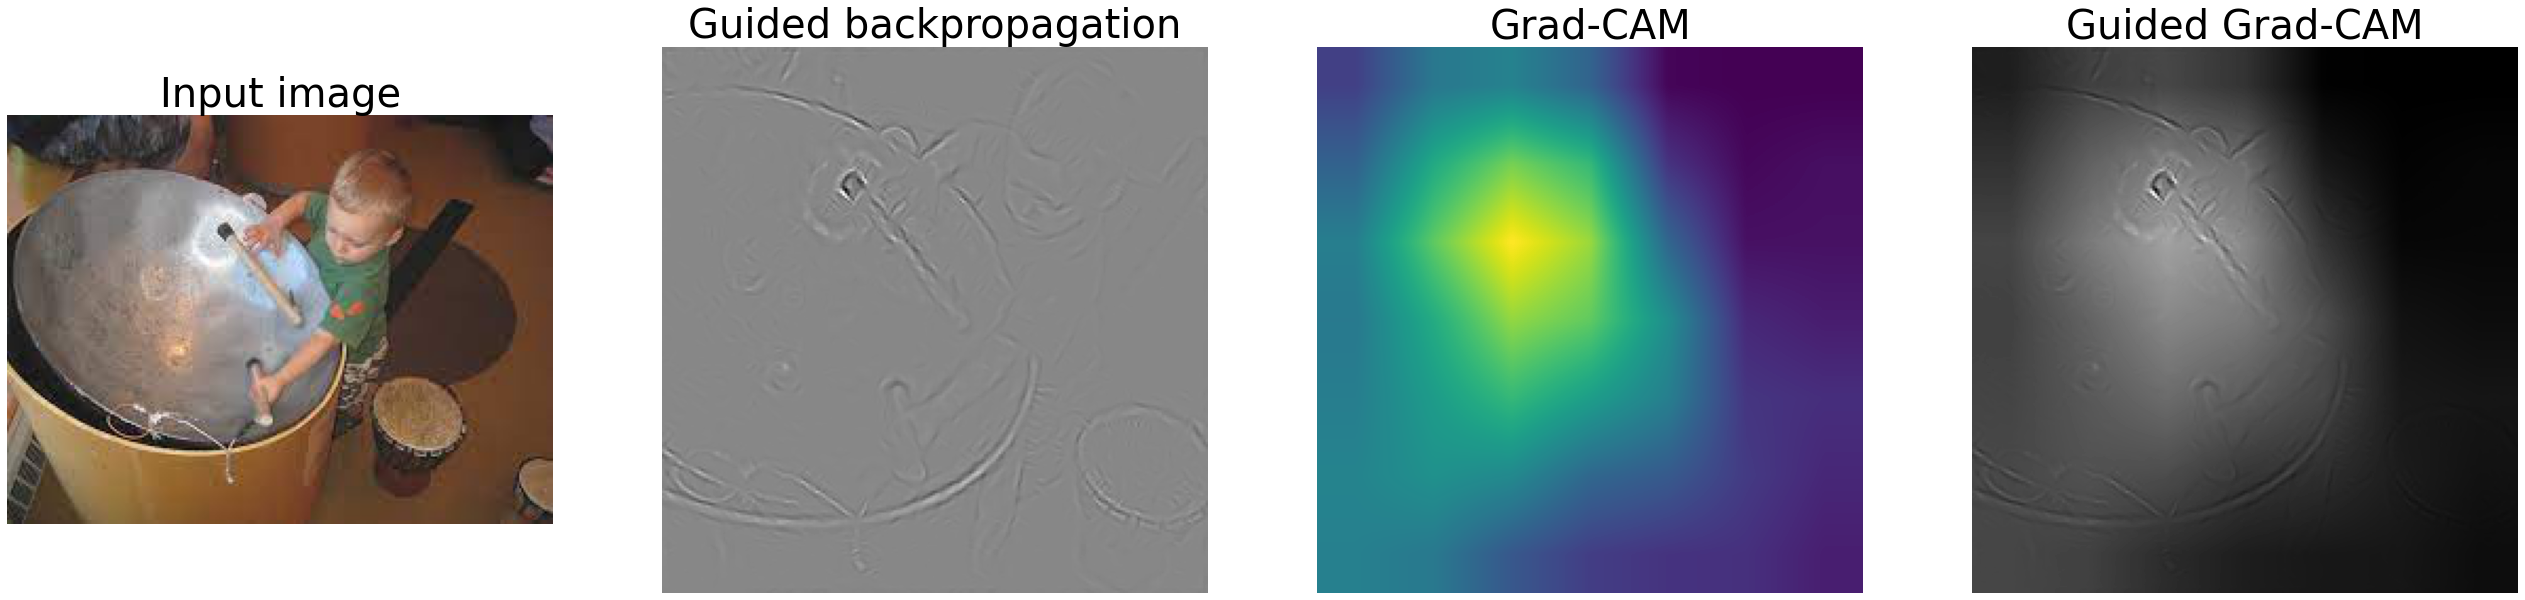

In [ ]:
path = paths[2]
print("3===========================================================")
heatmap = grad_cam(path)
grads = guided_backprop(path, info=False)
res = np.multiply(heatmap, grads)
plot_guided_grad_cam(heatmap, grads, res)

4===========================================================
television 0.18321867287158966
desk 0.1597985476255417
screen 0.13330484926700592
entertainment center 0.12984569370746613
desktop computer 0.07437697052955627


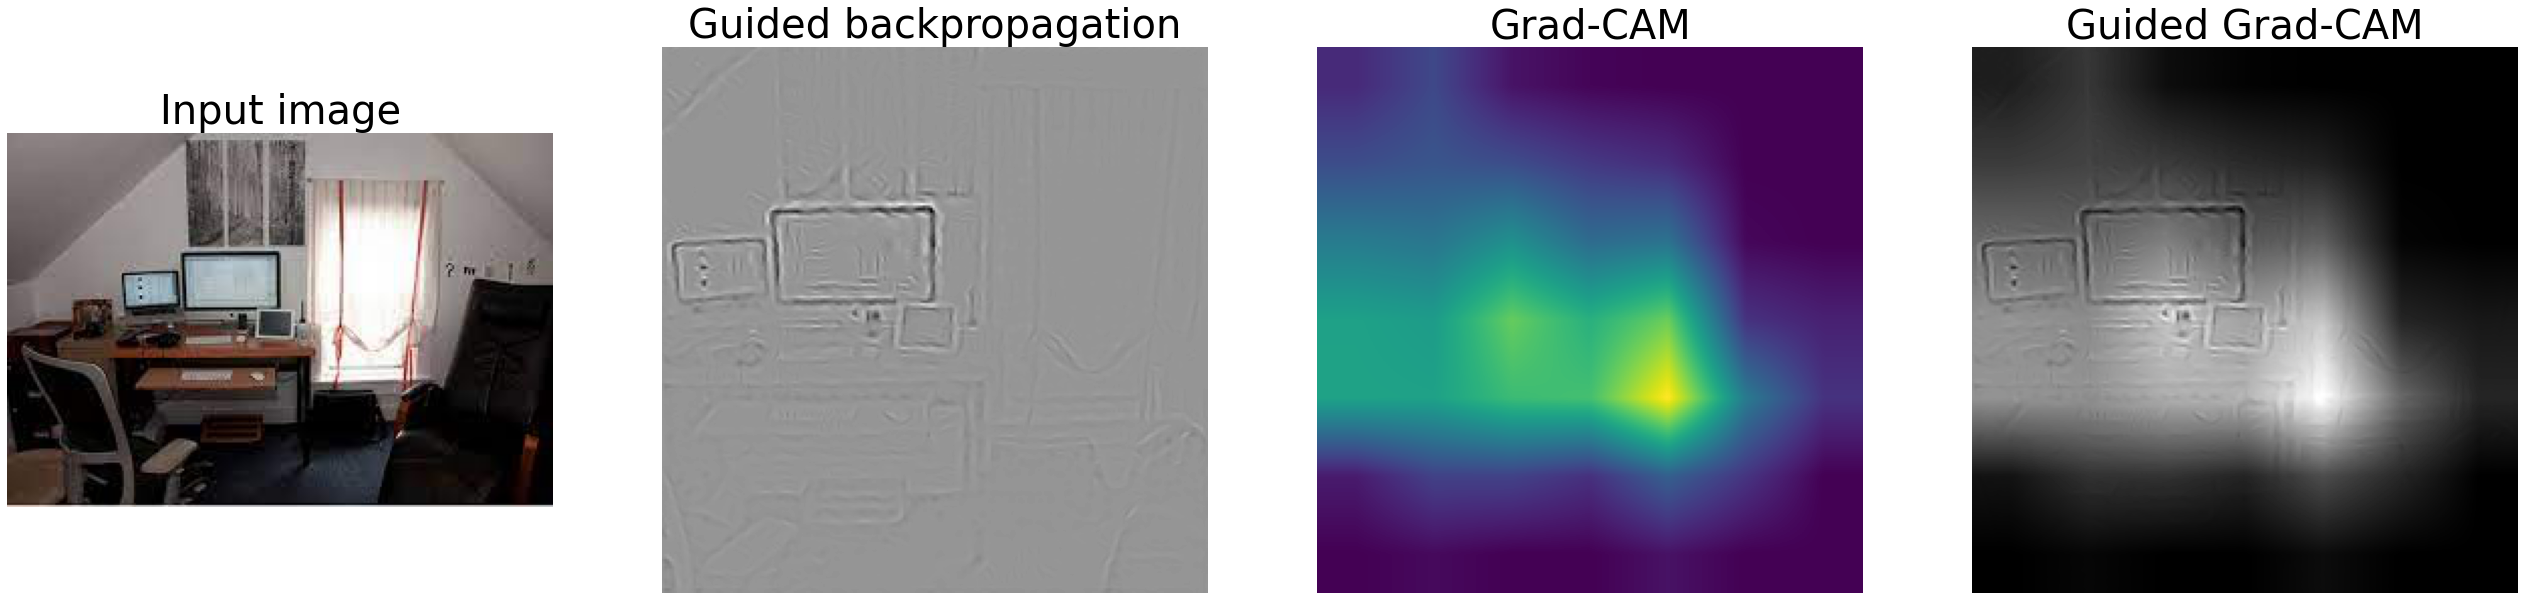

In [ ]:
path = paths[3]
print("4===========================================================")
heatmap = grad_cam(path)
grads = guided_backprop(path, info=False)
res = np.multiply(heatmap, grads)
plot_guided_grad_cam(heatmap, grads, res)

5===========================================================
tiger cat 0.6651792526245117
tabby 0.1787453293800354
Egyptian cat 0.024839093908667564
window screen 0.009130040183663368
space heater 0.006628428585827351


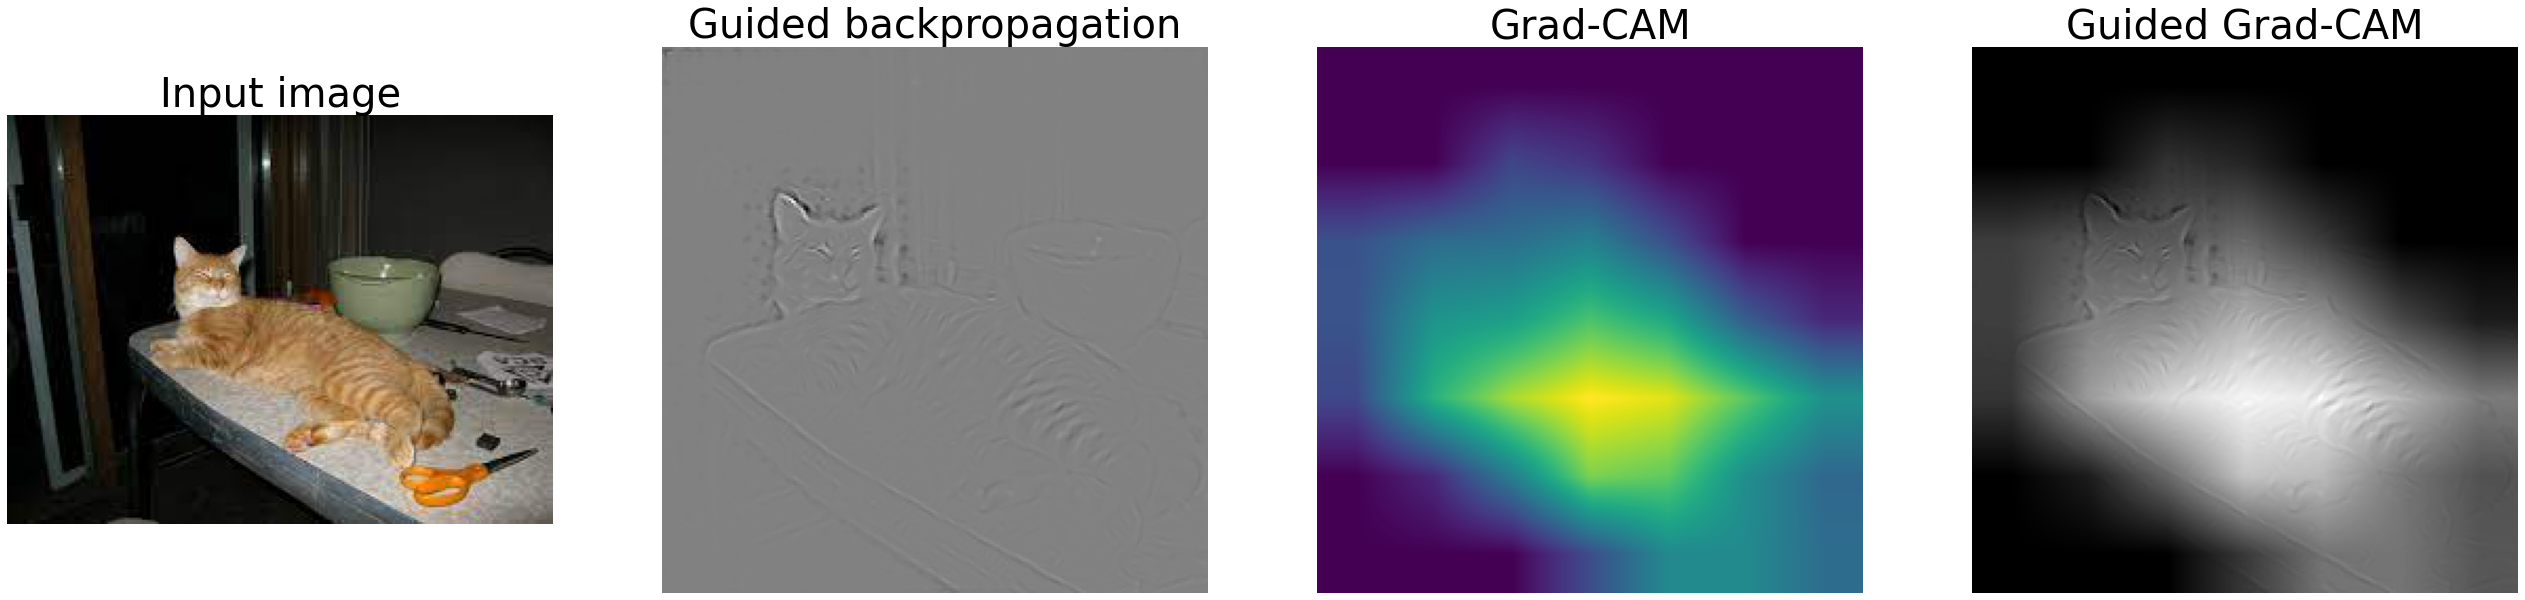

In [ ]:
path = paths[4]
print("5===========================================================")
heatmap = grad_cam(path)
grads = guided_backprop(path, info=False)
res = np.multiply(heatmap, grads)
plot_guided_grad_cam(heatmap, grads, res)

# 2. SGD Update rule variations

In [ ]:
def func(x: float, y: float) -> float:
  f_xy = 10 * (x ** 2) + (y ** 2)
  return f_xy

def gradient_func(x: float, y: float) -> np.ndarray:
  gradient = np.array([20 * x, 2 * y])
  return gradient

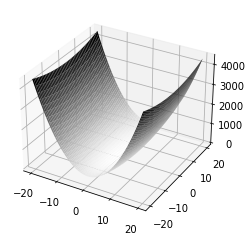

In [ ]:
r_min, r_max = -20, 20
xaxis = np.arange(r_min, r_max, 0.1)
yaxis = np.arange(r_min, r_max, 0.1)
x, y = np.meshgrid(xaxis, yaxis)
results = func(x, y)
figure = plt.figure()
axis = plt.axes(projection='3d')
axis.plot_surface(x, y, results, cmap='binary')
# show the plot
plt.show()

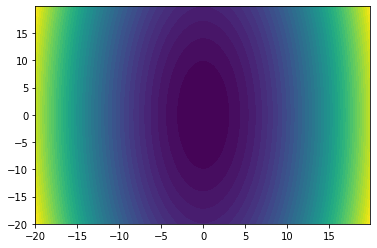

In [ ]:
bounds = np.asarray([[r_min, r_max], [r_min, r_max]])
xaxis = np.arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = np.arange(bounds[1,0], bounds[1,1], 0.1)
x, y = np.meshgrid(xaxis, yaxis)
results = func(x, y)
plt.contourf(x, y, results, levels=50, cmap='viridis')
plt.show()

In [ ]:
def vanilla_SGD(starting_point: np.ndarray, number_of_iterations: int = 50, learning_rate: float = 0.01):
  current_point = starting_point
  points_traversed = [starting_point]

  for i in range(number_of_iterations):
    gradient = gradient_func(current_point[0], current_point[1])
    current_point = current_point - (learning_rate * gradient)
    points_traversed.append(current_point)

  return points_traversed

def SGD_with_momentum(starting_point: np.ndarray, number_of_iterations: int = 50, learning_rate: float = 0.01, friction: float = 0.9):
  current_point = starting_point
  points_traversed = [starting_point]
  velocity = np.zeros_like(starting_point)
  for i in range(number_of_iterations):
    gradient = gradient_func(current_point[0], current_point[1])
    velocity = (friction * velocity) + gradient
    current_point = current_point - (learning_rate * velocity)
    points_traversed.append(current_point)

  return points_traversed

def nesterov_momentum(starting_point: np.ndarray, number_of_iterations: int = 50, learning_rate: float = 0.01, friction: float = 0.9):
  current_point = starting_point
  points_traversed = [starting_point]
  velocity = np.zeros_like(starting_point)
  for i in range(number_of_iterations):
    look_ahead_point = current_point + (friction * velocity)
    gradient = gradient_func(look_ahead_point[0], look_ahead_point[1])
    velocity = (friction * velocity) - (learning_rate * gradient)
    current_point = current_point + velocity
    points_traversed.append(current_point)

  return points_traversed

def adagrad(starting_point: np.ndarray, number_of_iterations: int = 50, learning_rate: float = 0.1, epsilon: float = 1e-4):
  current_point = starting_point
  points_traversed = [starting_point]
  grad_sq = np.zeros_like(starting_point)
  for i in range(number_of_iterations):
    gradient = gradient_func(current_point[0], current_point[1])
    grad_sq += (gradient ** 2)
    current_point = current_point - ((learning_rate * gradient) / (np.sqrt(grad_sq) + epsilon))
    points_traversed.append(current_point)

  return points_traversed

def RMSprop(starting_point: np.ndarray, number_of_iterations: int = 50, learning_rate: float = 0.1, epsilon: float = 1e-4, friction: float = 0.9):
  current_point = starting_point
  points_traversed = [starting_point]
  grad_sq = np.zeros_like(starting_point)
  for i in range(number_of_iterations):
    gradient = gradient_func(current_point[0], current_point[1])
    grad_sq = (friction * grad_sq) + ((1 - friction) * (gradient ** 2))
    current_point = current_point - ((learning_rate * gradient) / (np.sqrt(grad_sq) + epsilon))
    points_traversed.append(current_point)

  return points_traversed

In [ ]:
start_point = np.array([np.random.uniform(-20, 20), np.random.uniform(-20, 20)])
print(start_point)

vanilla_path = vanilla_SGD(start_point, number_of_iterations=100, learning_rate=0.01)
sgd_momentum_path = SGD_with_momentum(start_point, number_of_iterations=100, learning_rate=0.01, friction=0.9)
nesterov_path = nesterov_momentum(start_point, number_of_iterations=100, learning_rate=0.01, friction=0.9)
adagrad_path = adagrad(start_point, number_of_iterations=100, learning_rate=0.1, epsilon=1e-4)
rmsprop_path = RMSprop(start_point, number_of_iterations=100, learning_rate=0.1, epsilon=1e-4, friction=0.9)

[ 12.12778734 -15.09879402]


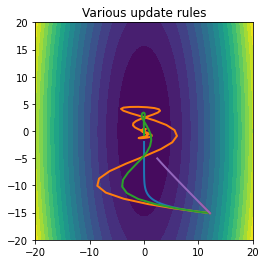

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim((-20, 20))
ax.set_ylim((-20, 20))
ax.set_aspect('equal')
ax.set_title('Various update rules')
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)
ax.contourf(X, Y, Z, levels=20, cmap='viridis')
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line4, = ax.plot([], [], lw=2)
line5, = ax.plot([], [], lw=2)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    return (line1, line2, line3, line4, line5)

def update(frame):
    xdata, ydata = line1.get_data()
    xdata = np.append(xdata, vanilla_path[frame][0])
    ydata = np.append(ydata, vanilla_path[frame][1])
    line1.set_data(xdata, ydata)

    xdata, ydata = line2.get_data()
    xdata = np.append(xdata, sgd_momentum_path[frame][0])
    ydata = np.append(ydata, sgd_momentum_path[frame][1])
    line2.set_data(xdata, ydata)

    xdata, ydata = line3.get_data()
    xdata = np.append(xdata, nesterov_path[frame][0])
    ydata = np.append(ydata, nesterov_path[frame][1])
    line3.set_data(xdata, ydata)

    xdata, ydata = line4.get_data()
    xdata = np.append(xdata, adagrad_path[frame][0])
    ydata = np.append(ydata, adagrad_path[frame][1])
    line4.set_data(xdata, ydata)

    xdata, ydata = line5.get_data()
    xdata = np.append(xdata, rmsprop_path[frame][0])
    ydata = np.append(ydata, rmsprop_path[frame][1])
    line5.set_data(xdata, ydata)

    return (line1, line2, line3, line4, line5)

ani = animation.FuncAnimation(fig, update, frames=100+1, init_func=init, blit=True)
ani.save('temp.gif', writer='imagemagick', fps=10)